### Requirements & Configurations

In [1]:
import sys  
sys.path.insert(0, '../')

In [2]:
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from catboost import CatBoostClassifier, Pool

from torch import nn
from IPython.display import clear_output
from tqdm import tqdm_notebook, tqdm
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from itertools import repeat
from data import *

import torch
import torch.nn.utils.prune as prune
import torch.nn.functional as F

import core.data.rich_utils as rich_utils

import wandb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os

%matplotlib inline

In [3]:
PARTICLE_TYPE = 'pion'

BATCH_SIZE = 4096
BATCH_SIZE_VAL = 1024
LATENT_DIMENSIONS = 128
NOISE_SIZE = 128
CRAMER_DIM = 512
NUM_LAYERS = 10

CRITIC_ITERATIONS_CONST = 10
TOTAL_ITERATIONS = int(6e4)
VALIDATION_INTERVAL = 10000

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Load dataset

In [4]:
from core.data.datasets import ParticleDataset
               

data_train, data_val, scaler = rich_utils.get_merged_typed_dataset(PARTICLE_TYPE, dtype=np.float32)
    
train_loader = torch.utils.data.DataLoader(ParticleDataset(data_train.values),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    pin_memory=True)

val_loader = torch.utils.data.DataLoader(ParticleDataset(data_val.values),
                                                  batch_size=BATCH_SIZE_VAL,
                                                  shuffle=False,
                                                  pin_memory=True)

scaler train sample size: 1500000
scaler n_quantiles: 100000, time = 1.965419054031372


In [5]:
data_train.head(3)

RichDLLe  RichDLLk  RichDLLmu  RichDLLp  RichDLLbt  Brunel_P  Brunel_ETA  \
0  0.482666  0.053458   0.053947 -0.548041   0.269786  0.720969    0.676907   
1  1.486169 -0.762816   1.142220 -0.881954  -0.295823  0.421586   -1.315679   
2 -0.659258  0.147714  -0.582184  0.318019   0.308314 -0.715213    0.341952   

   nTracks_Brunel  probe_sWeight  
0        0.097714       0.883707  
1        0.559815       0.912539  
2        1.057633       1.086270

### Load a model 

In [6]:
class Generator(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(LATENT_DIMENSIONS + data_train.shape[1] - 1 - rich_utils.y_count, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(0.1),
            *[nn.Sequential(
                nn.utils.spectral_norm(nn.Linear(hidden_size, hidden_size)),
                nn.BatchNorm1d(hidden_size),
                nn.LeakyReLU(0.1)) for _ in range(depth)
             ],
            nn.Linear(hidden_size, rich_utils.y_count),
        )

    def forward(self, x, noise=None):
        return self.layers(torch.cat([x, get_noise(x.shape[0])], dim=1))

    
class Critic(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Critic, self).__init__()
        self.layers = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(data_train.shape[1] - 1, hidden_size)),
            nn.LayerNorm(hidden_size),
            nn.LeakyReLU(0.1),
            *[nn.Sequential(
                nn.utils.spectral_norm(nn.Linear(hidden_size, hidden_size)),
                nn.LayerNorm(hidden_size),
                nn.LeakyReLU(0.1))
              for _ in range(depth)],
            nn.utils.spectral_norm(nn.Linear(hidden_size, 1)),
        )

    def forward(self, x):
        return self.layers(x)

    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

        
def get_noise(batch_size, mean=0, std=1):
    return torch.zeros(batch_size, LATENT_DIMENSIONS).normal_(mean, std).to(device)


def generate(generator):
    generator.eval()
    
    dlls = None
    generated = None
    weights = None
    features = None

    with torch.no_grad():
        for x, weight, real in val_loader:
            weight = weight.detach().cpu().numpy()
            dll = real.detach().cpu().numpy()
            x = x.to(device)
            gen = generator(x).detach().cpu().numpy()
            x = x.detach().cpu().numpy()

            if dlls is None:
                dlls = dll
            else:
                dlls = np.concatenate((dlls, dll))

            if weights is None:
                weights = weight
            else:
                weights = np.concatenate((weights, weight))

            if generated is None:
                generated = gen
            else:
                generated = np.concatenate((generated, gen))
            
            if features is None:
                features = x
            else:
                features = np.concatenate((features, x))
    return dlls, generated, weights, features

In [7]:
netG = Generator(depth=5).to(device)
netC = Critic(depth=5).to(device)

netC.load_state_dict(torch.load('../weights/C_teacher.pth', map_location={'cuda:3':device}))
netG.load_state_dict(torch.load('../weights/G_teacher.pth', map_location={'cuda:3':device}))

<All keys matched successfully>

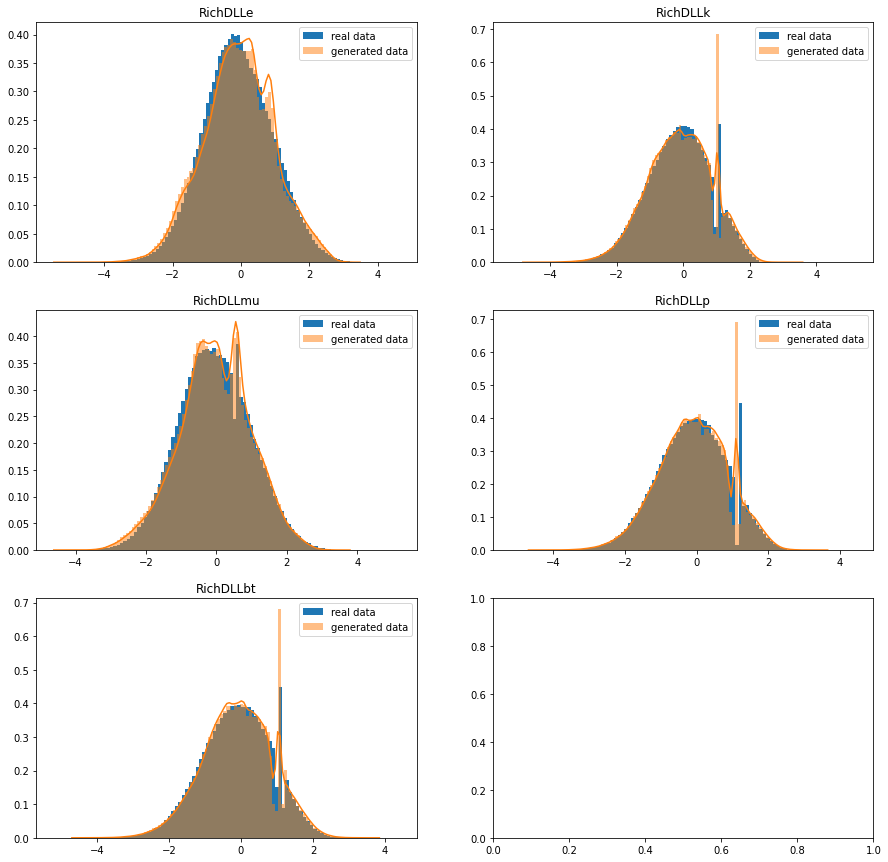

In [8]:
from core.metrics import hists

dlls, generated, weights, features = generate(netG)
hists.plot_1d_hist(dlls, generated, hist_kws={'weights': weights});

### Global prunning

In [9]:
from core.metrics import classification, kolmogorov_smirnov
from omegaconf.dictconfig import DictConfig

# stamp config
config = DictConfig({"metric": {"classification": {"iterations": 1000, "depth": None, "split_size": 0.99, "verbose_each_iter": 0}}, 
                     "utils": {"device": "cuda:0"}})

In [ ]:
import copy 

def global_pruning(prune_function, kwargs):
    pruning_metrics = {}
    for prune_amount in tqdm(range(0, 100, 10)):
        generator = copy.deepcopy(netG)
        pruning_metrics[prune_amount] = {}

        for layer in generator.layers:
            if isinstance(layer, torch.nn.Sequential):
                linear_layer = layer[0]
                prune_function(linear_layer, **kwargs)
                prune.remove(linear_layer, 'weight_orig')

        dlls, generated, weights, features = generate(generator)
        hists.plot_1d_hist(dlls, generated, hist_kws={'weights': weights})
        plt.savefig(f'global-{str(prune_function)}-{prune_amount / 100}.png')

        # kolmogorov-smirnov
        ks_metrics = []
        for i in range(5):
            ks_metrics.append(kolmogorov_smirnov.ks_2samp_w(dlls[:, i], generated[:, i], weights, weights))
        pruning_metrics[prune_amount]['ks'] = ks_metrics

        # roc auc
        pruning_metrics[prune_amount]['auc'] = classification.calculate_rocauc(config, pd.DataFrame(features, columns=['a', 'b', 'c']), pd.DataFrame(dlls), pd.DataFrame(generated), weights)
        
        
# get metrics of different pruning functions
pruning_metrics = []
functions = [prune.l1_unstructured, prune.ln_structured]
parametrs = [{name='weight_orig', amount=prune_amount / 100},
             {name='weight_orig', amount=prune_amount / 100, dim=0, n=2}]
for function in functions:
    pruning_metrics.append(global_pruning(function))

In [59]:
labels = ['unstructured l1', 'structured l2']

aucs = [[] for _ in labels]
ks_min = [[] for _ in labels]
ks_max = [[] for _ in labels]
ks_mean = [[] for _ in labels]
for idx, m in enumerate(pruning_metrics):
    for k, v in m.items():
        aucs[idx].append(v['auc'][0]) # get only weighed auc
        ks_mean[idx].append(np.mean(v['ks']))
        ks_max[idx].append(np.max(v['ks']))
        ks_min[idx].append(np.min(v['ks']))

#### plot  all metrics

<Figure size 432x288 with 0 Axes>

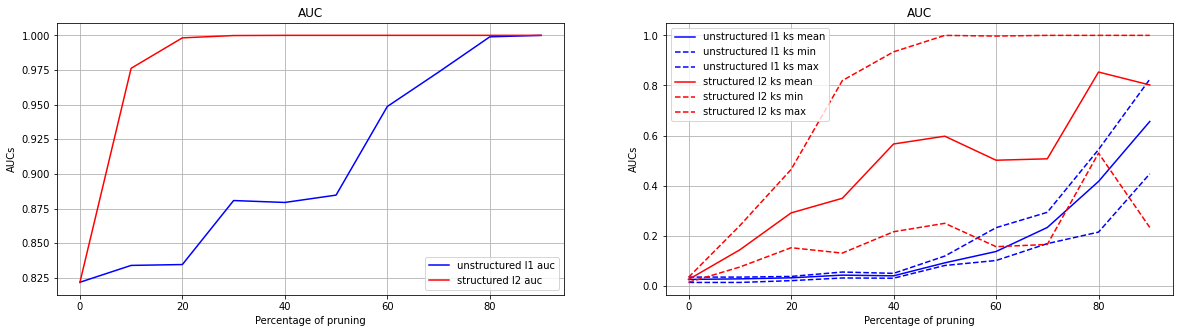

In [60]:
fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

x = list(range(0, 100, 10))
colors = ['b', 'r', 'g']

for idx, i in enumerate(labels):
    ax1.plot(x, aucs[idx], label=i + ' auc', color=colors[idx])

ax1.legend()
ax1.set_xlabel('Percentage of pruning')
ax1.set_ylabel('AUCs')
ax1.set_title('AUC')
ax1.grid()


for idx, i in enumerate(labels):
    ax2.plot(x, ks_mean[idx], label=i + ' ks mean', color=colors[idx])
    ax2.plot(x, ks_min[idx], label=i + ' ks min', color=colors[idx], linestyle='--')
    ax2.plot(x, ks_max[idx], label=i + ' ks max', color=colors[idx], linestyle='--')

ax2.legend()
ax2.set_xlabel('Percentage of pruning')
ax2.set_ylabel('Metric of kolmogorov-smirnov')
ax2.set_title('Kolmogorov-smirnov')
ax2.grid();

### Layer pruning

  0%|          | 0/10 [00:00<?, ?it/s]../core/metrics/hists.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(3, 2, figsize=(15, 15))
100%|██████████| 10/10 [11:12<00:00, 67.20s/it]


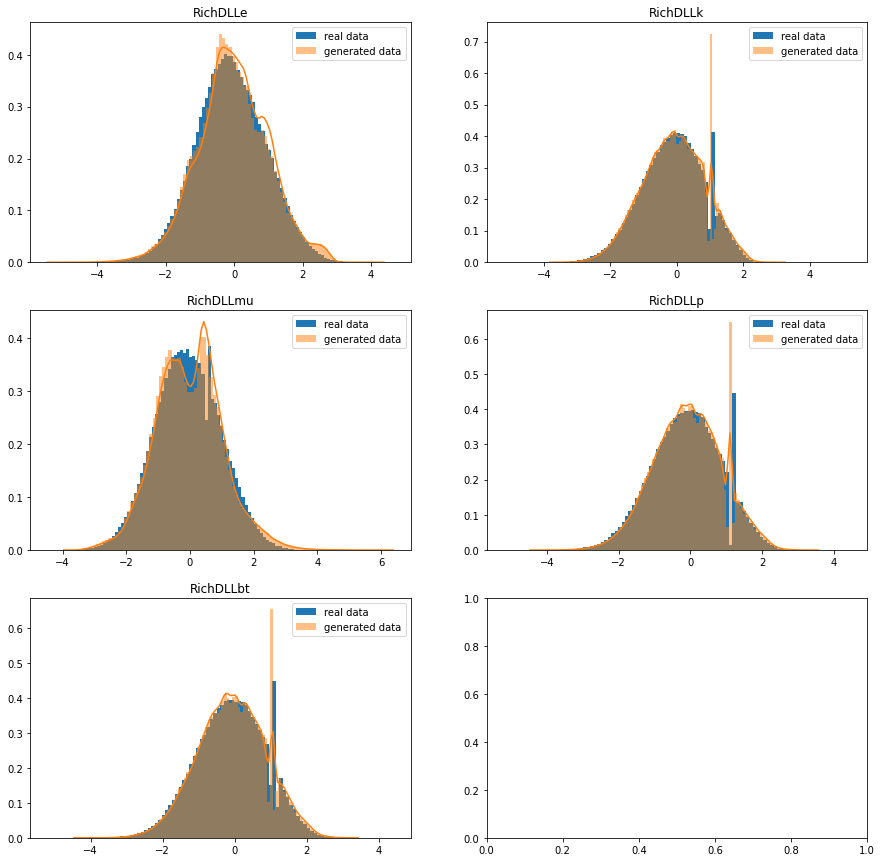

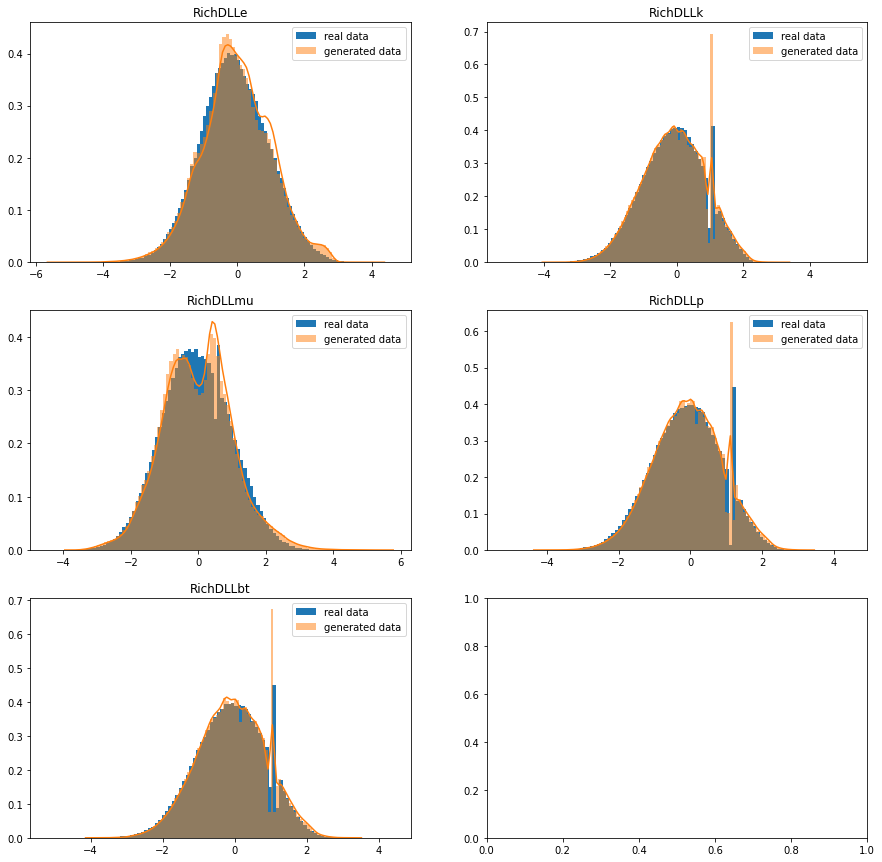

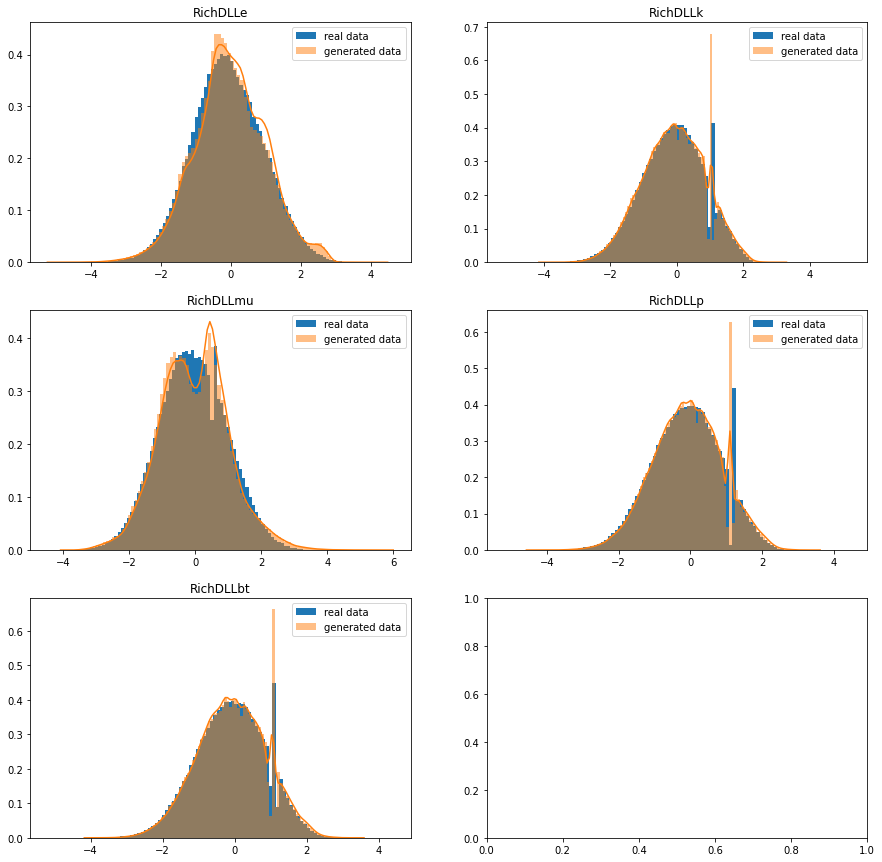

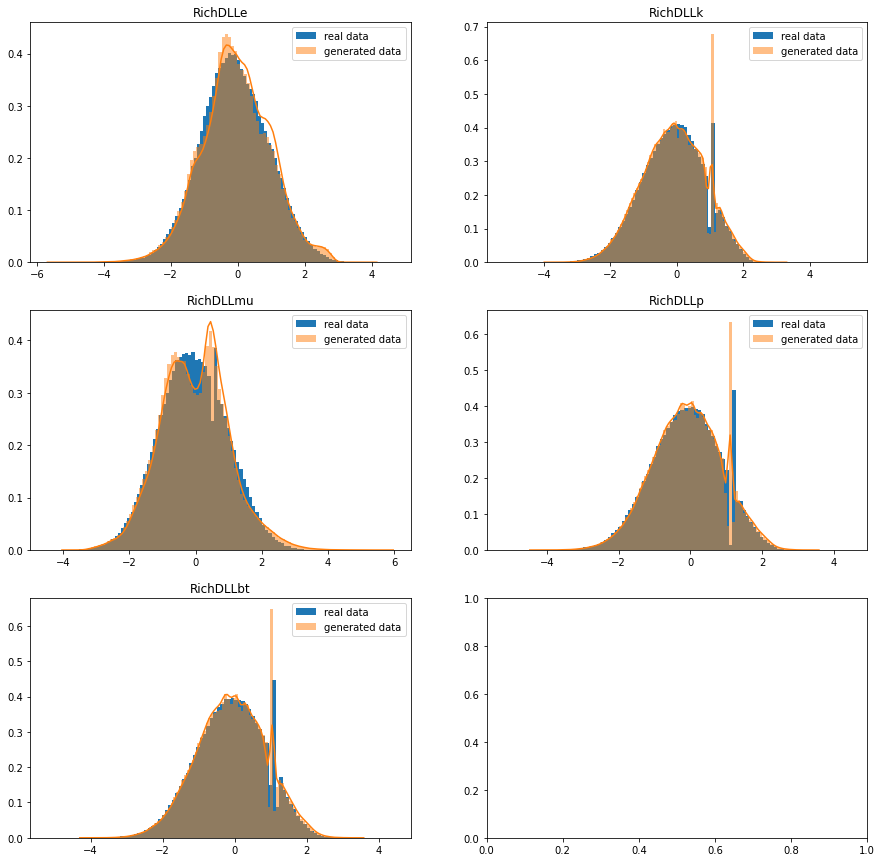

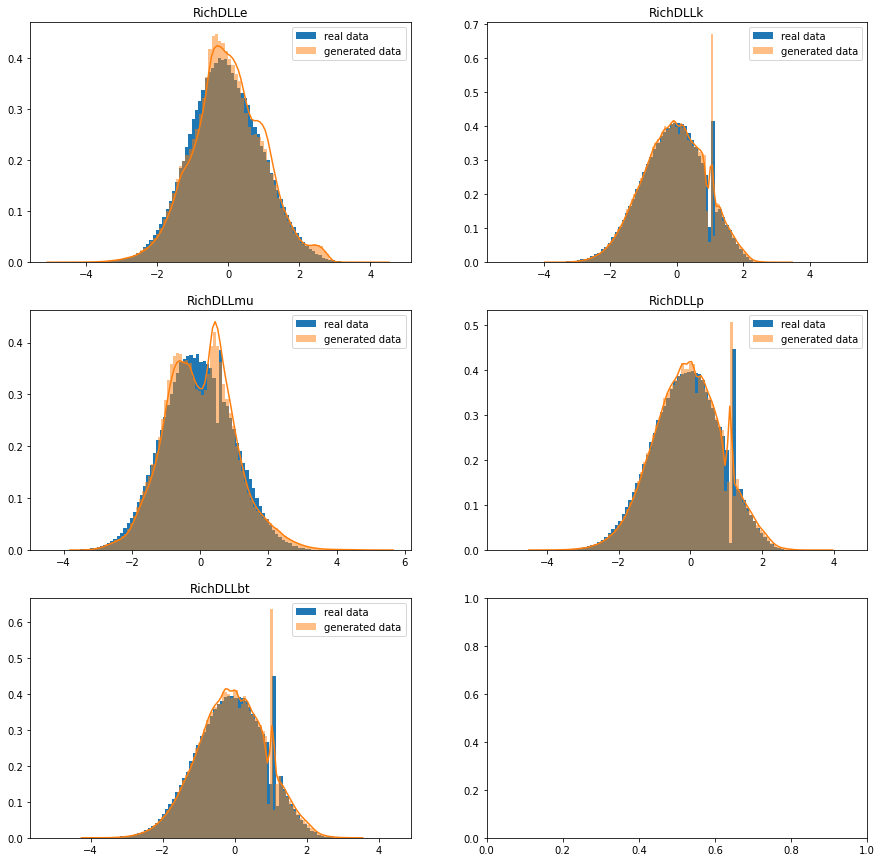

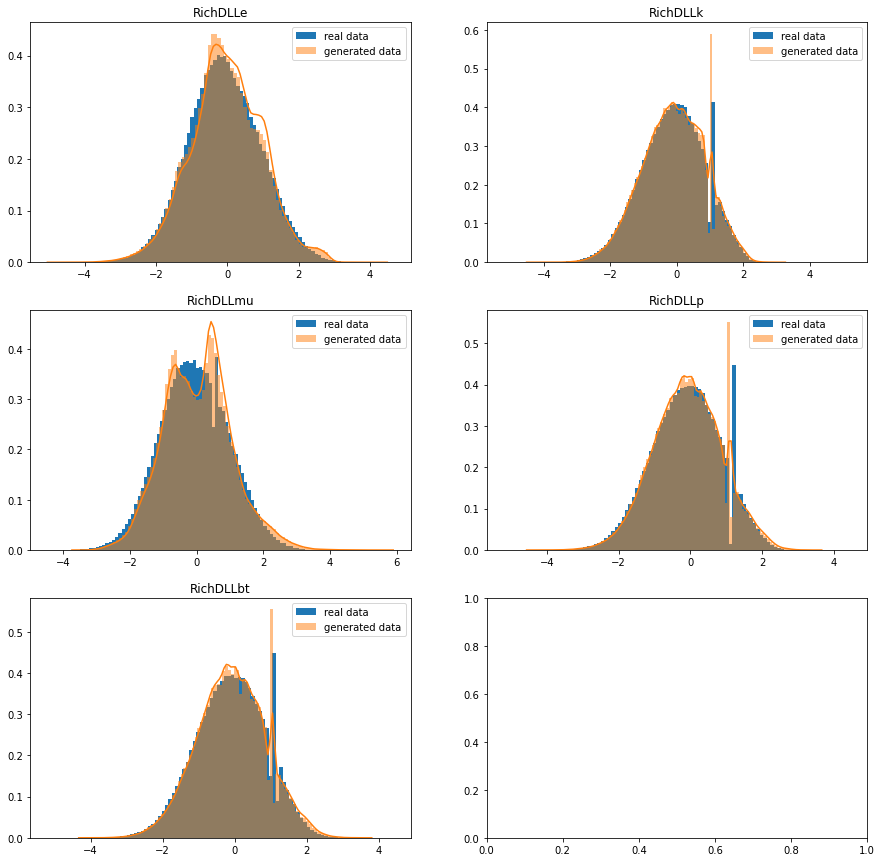

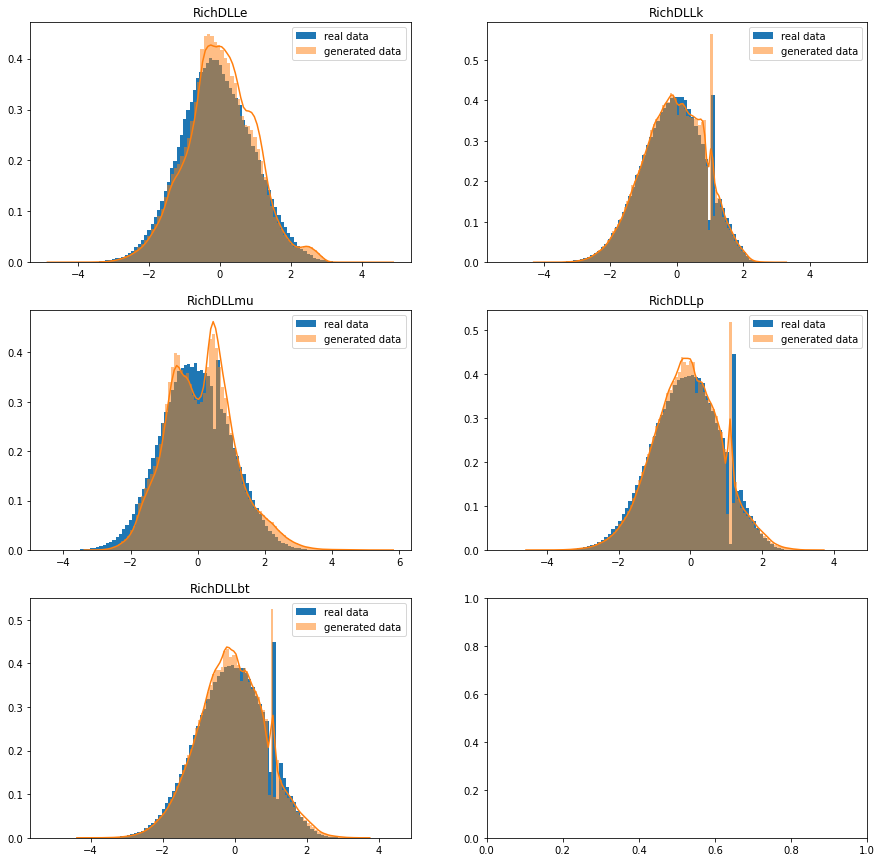

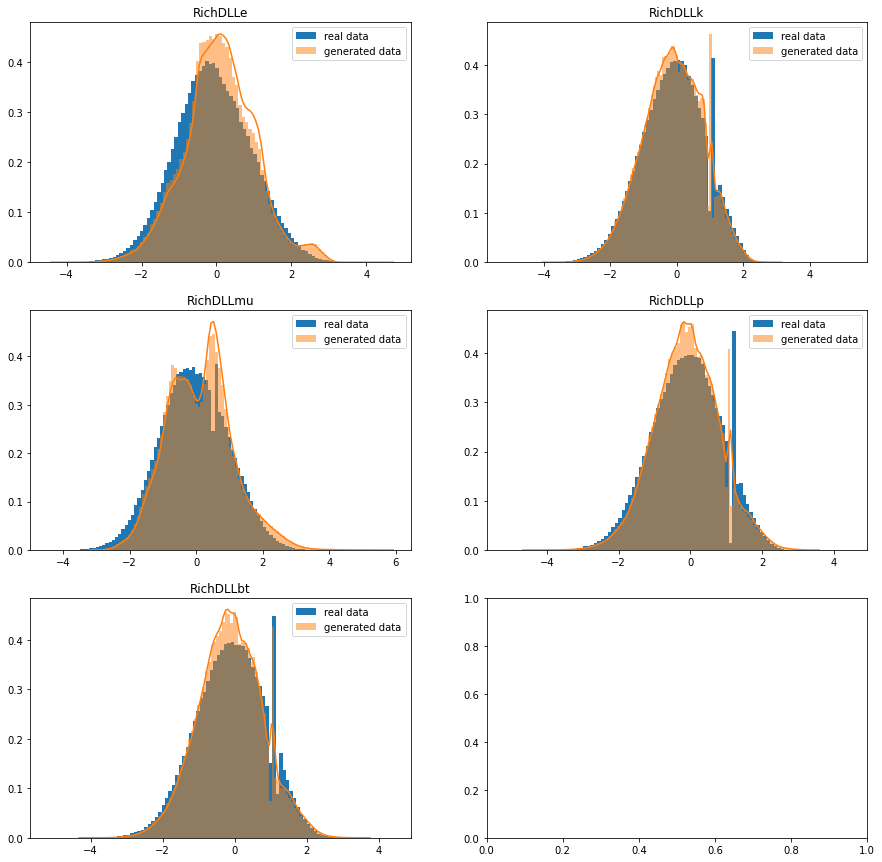

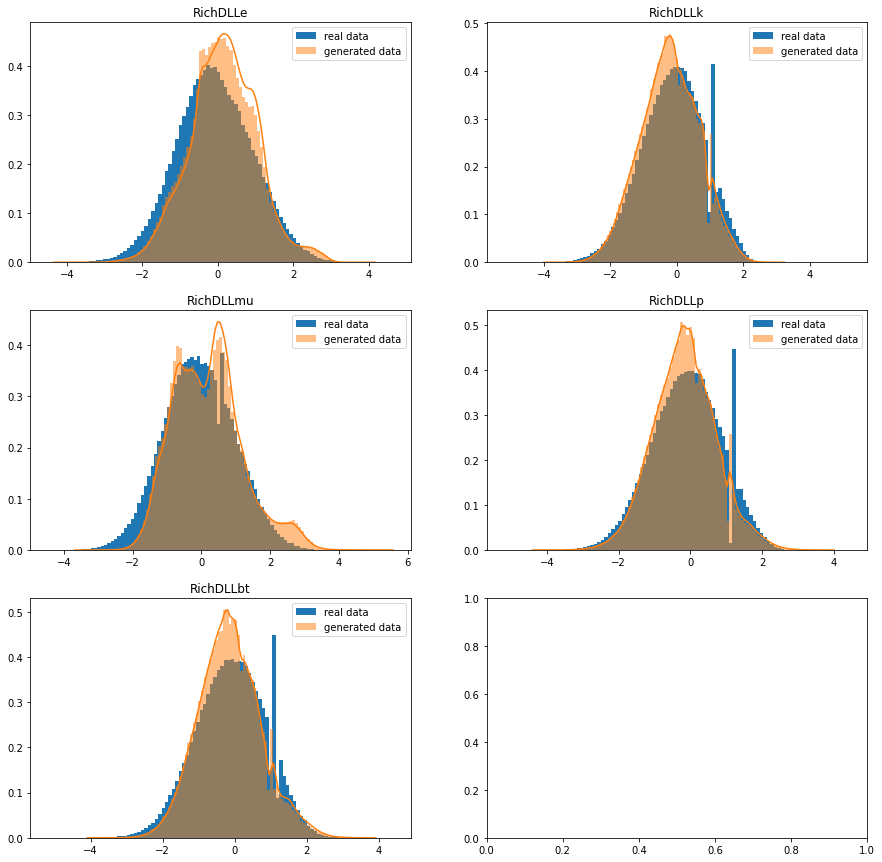

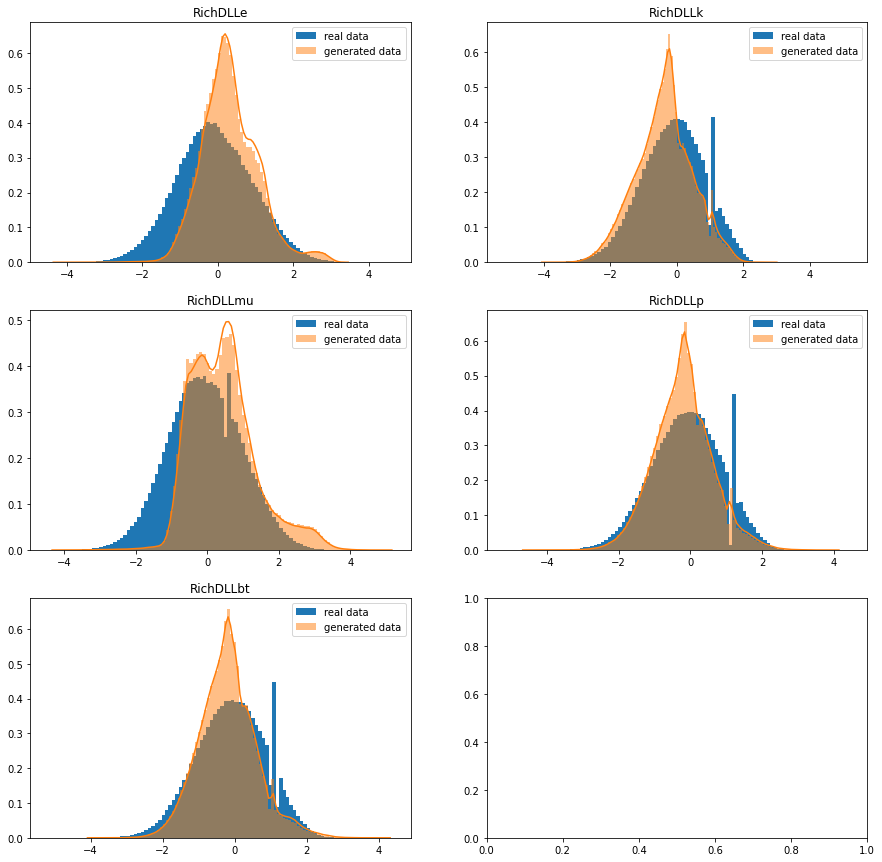

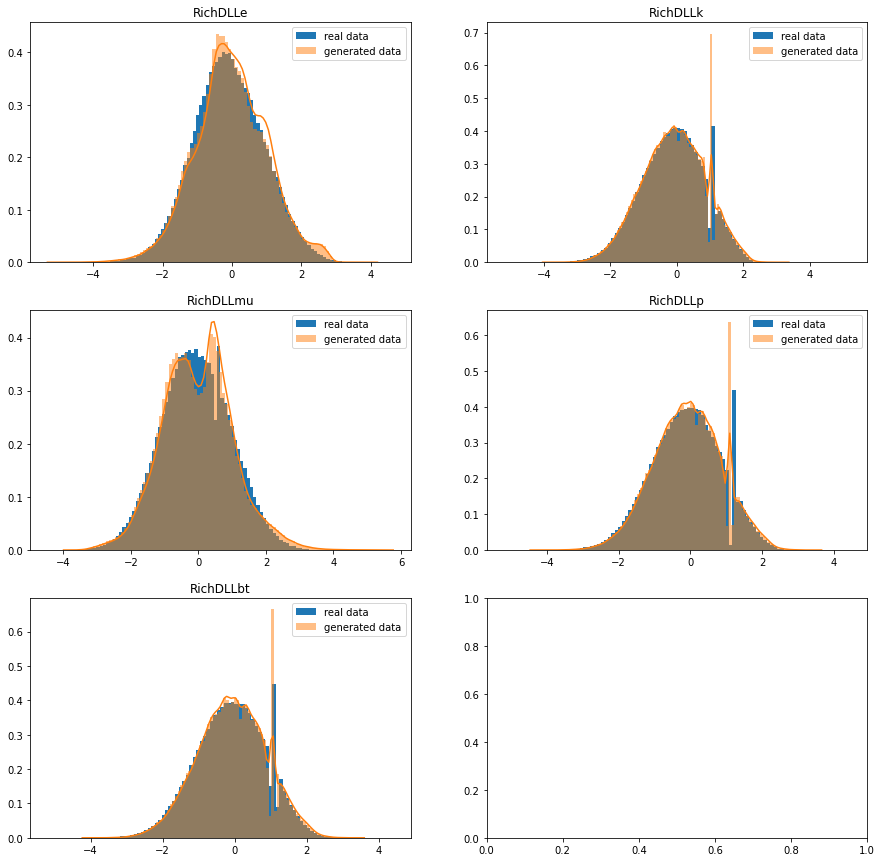

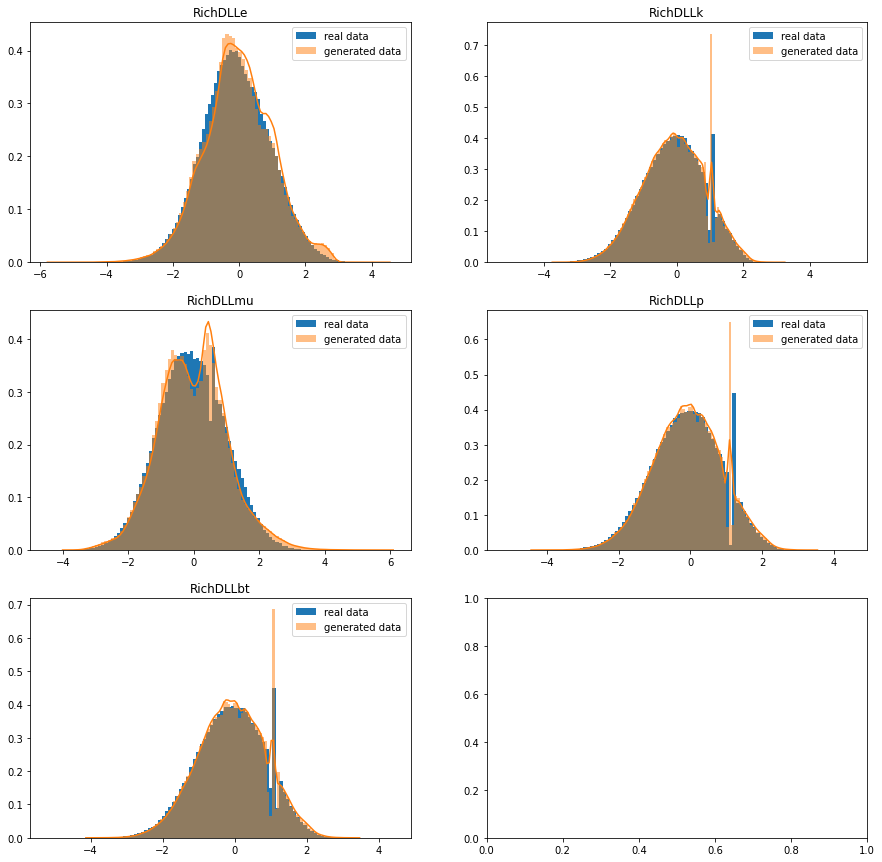

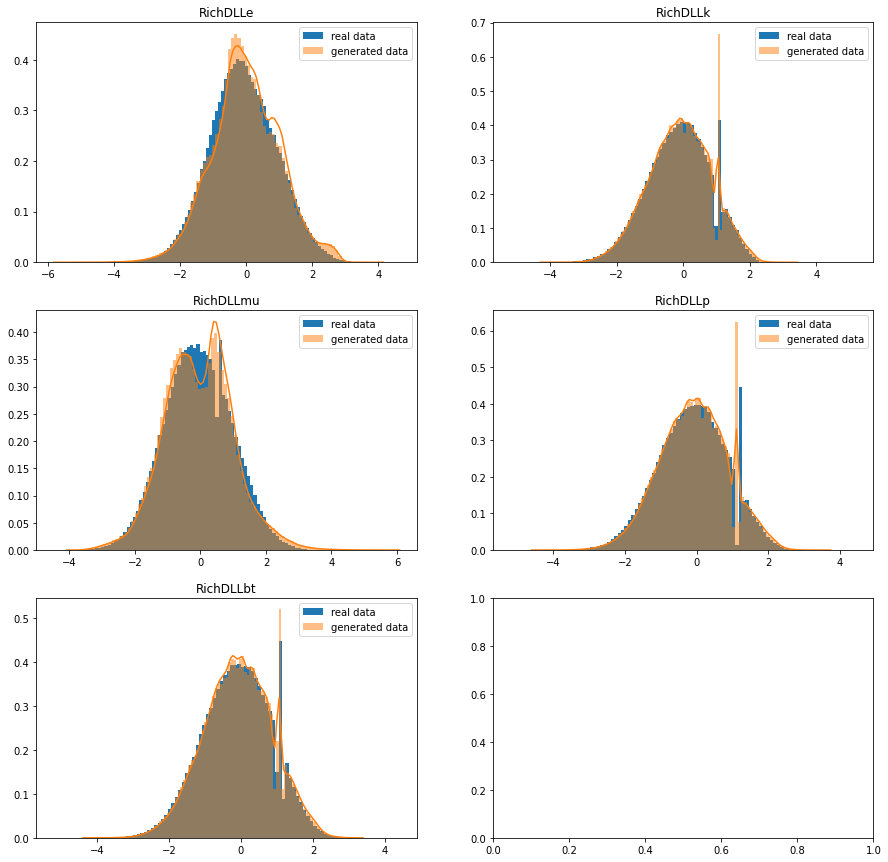

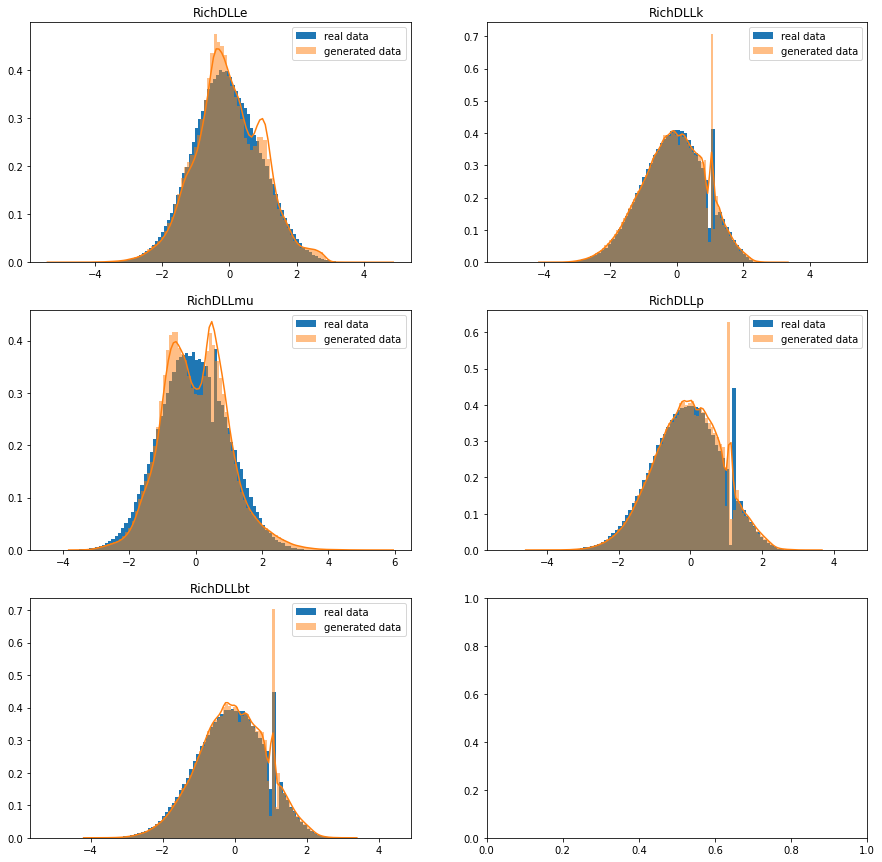

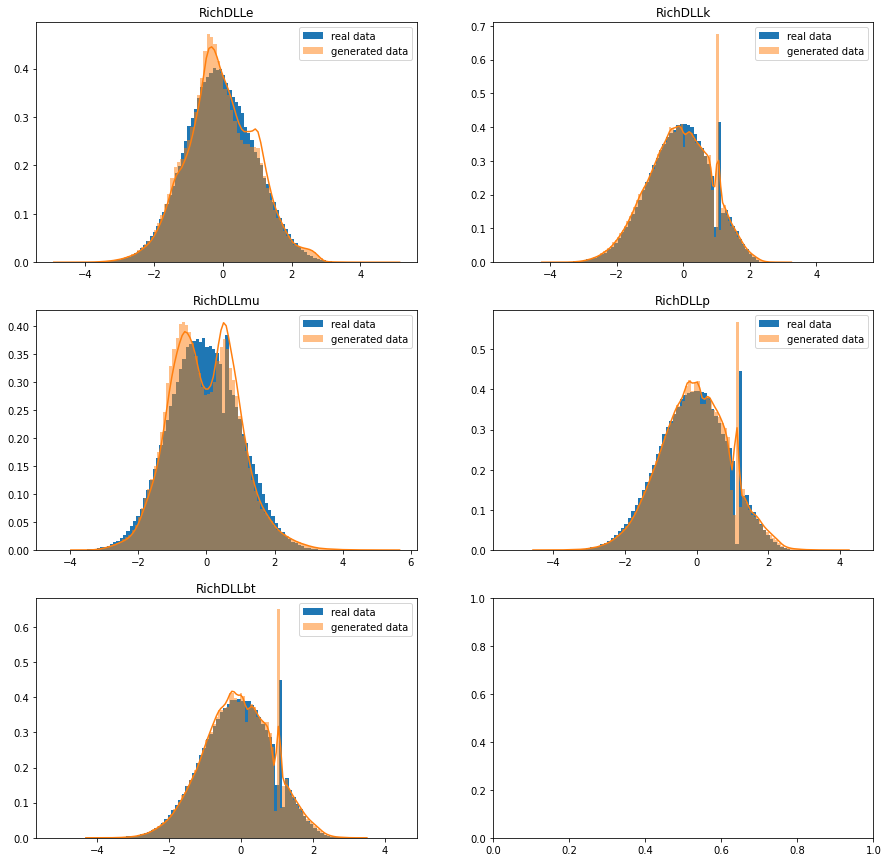

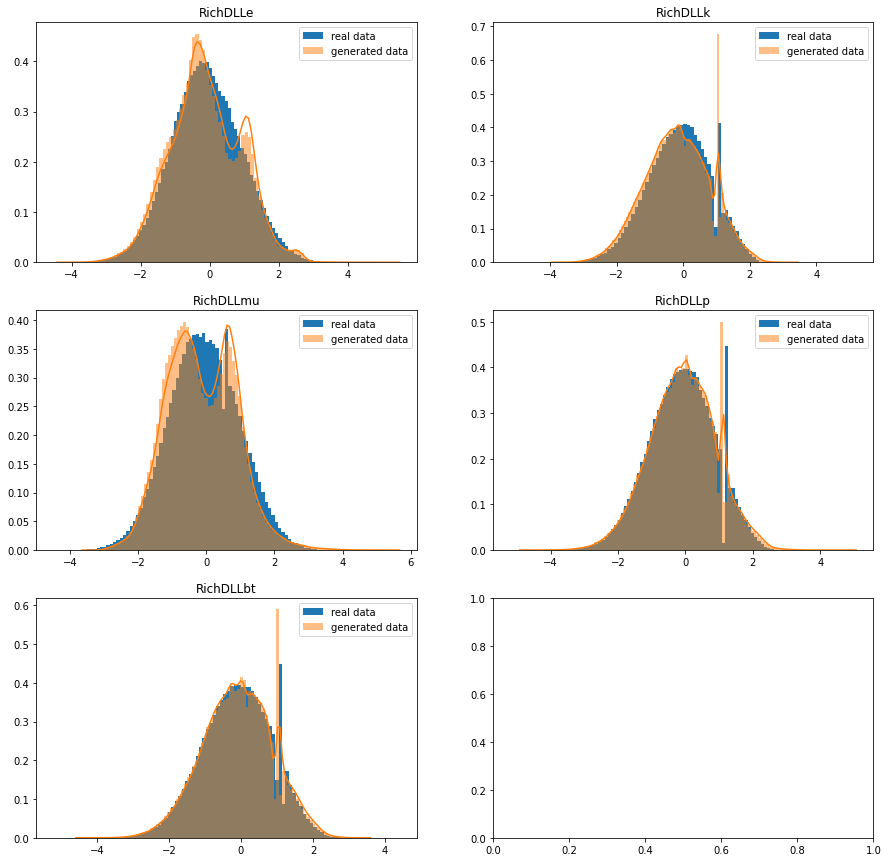

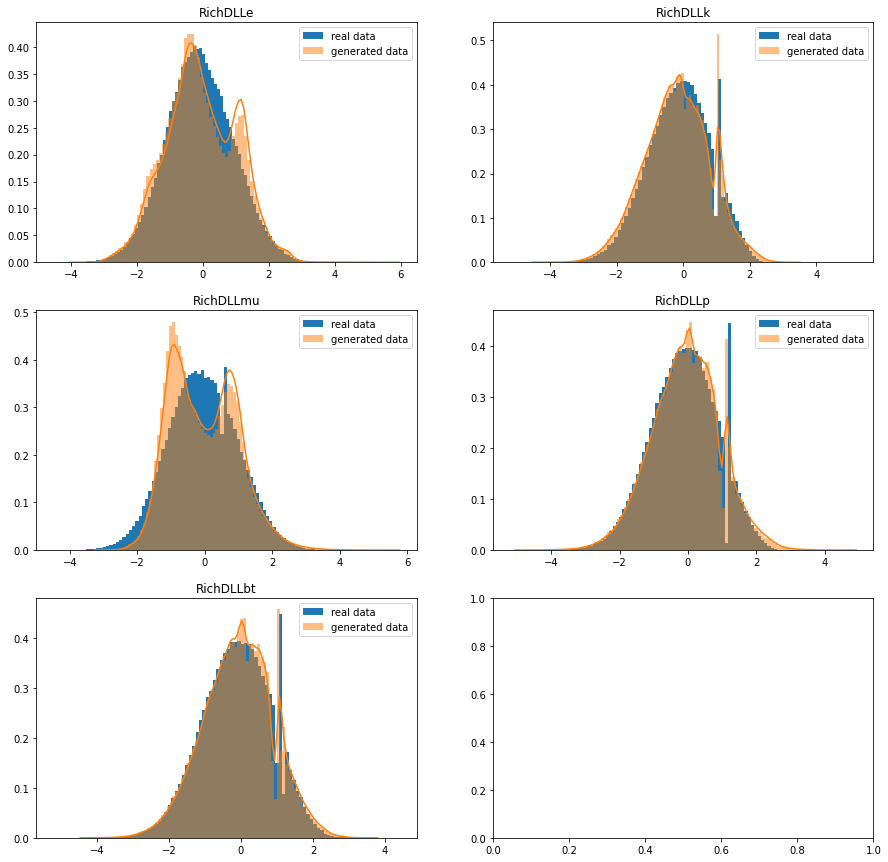

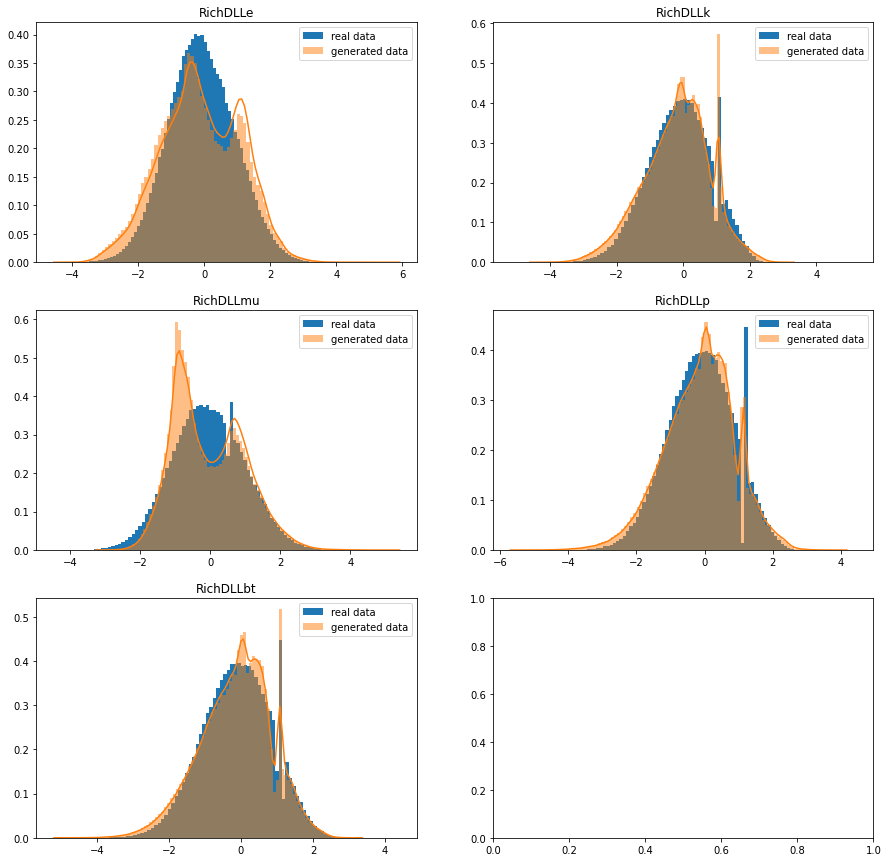

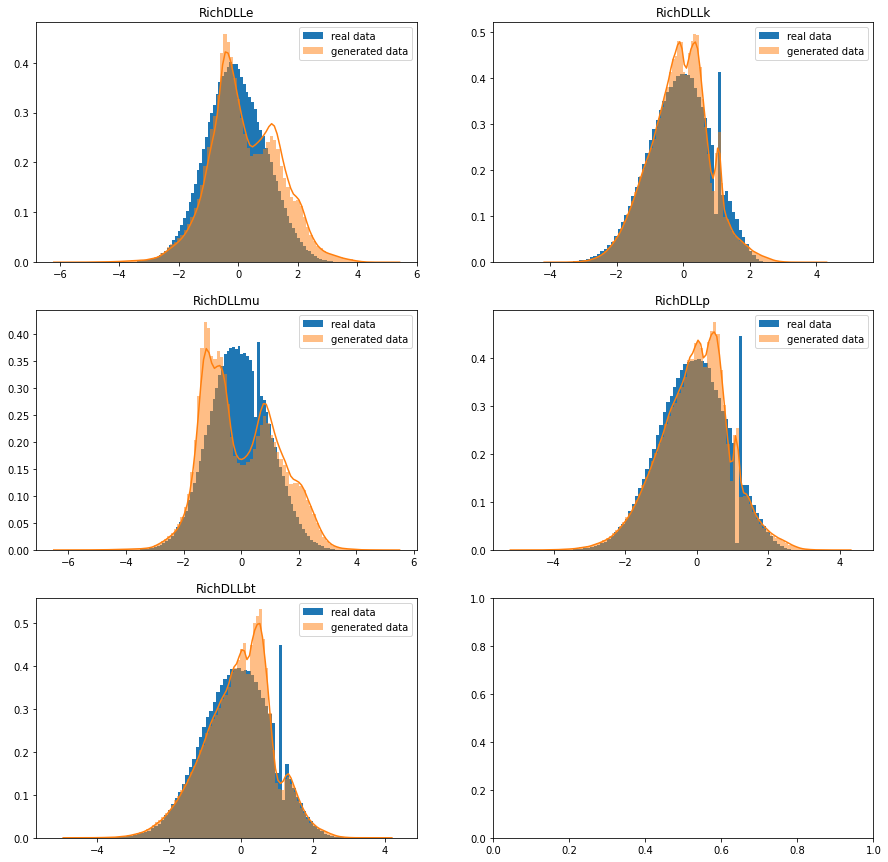

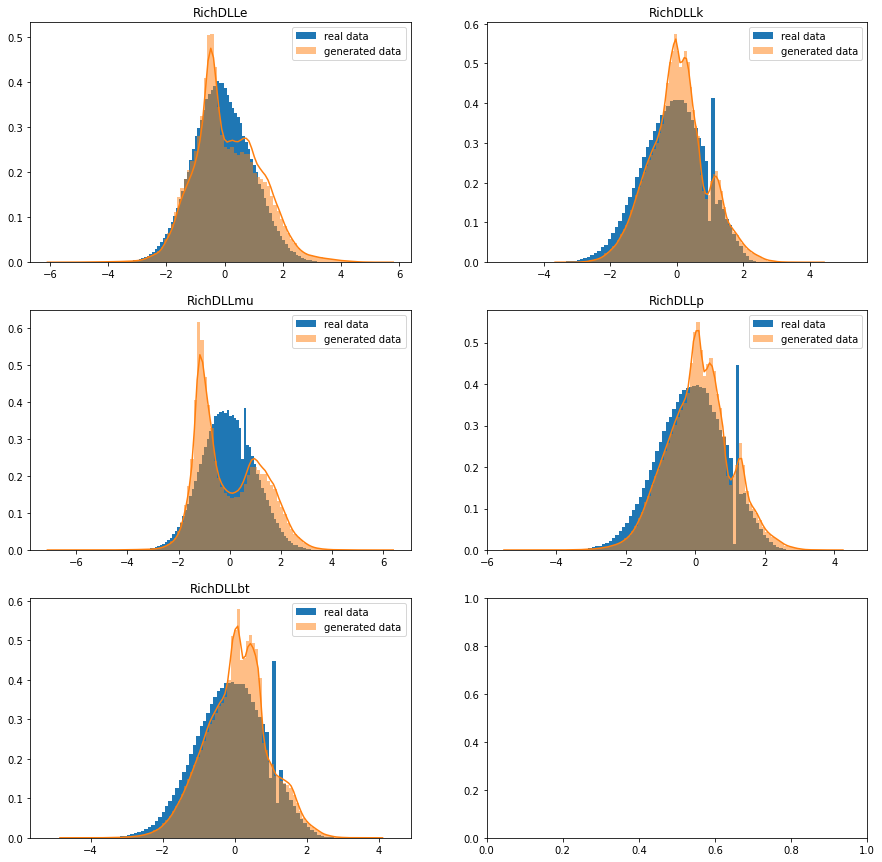

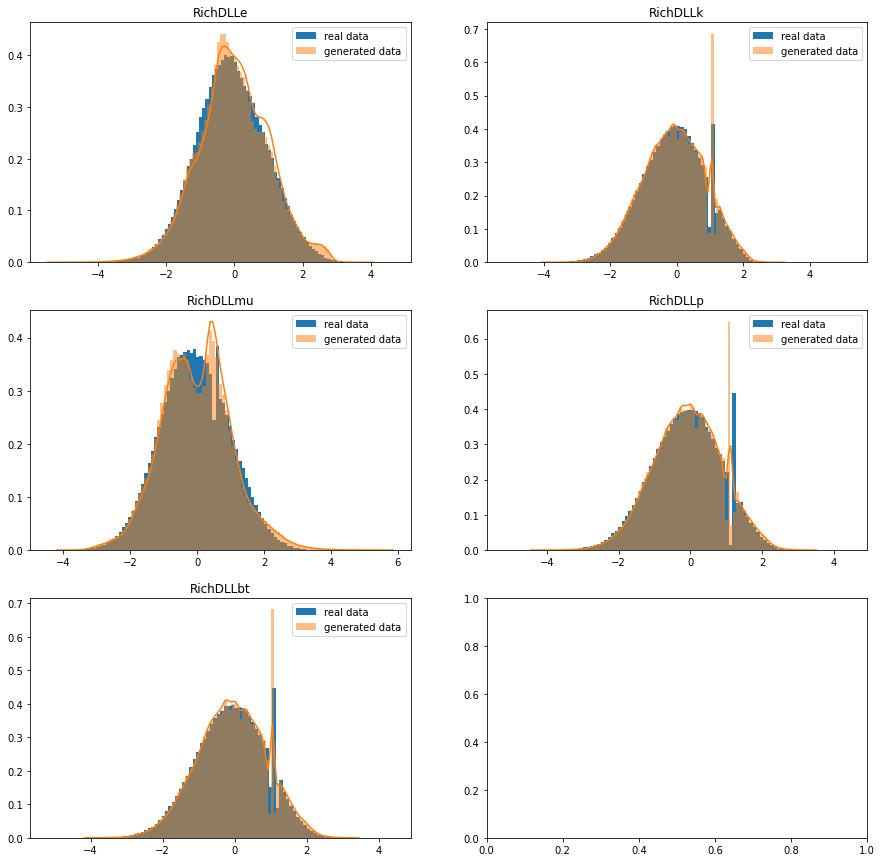

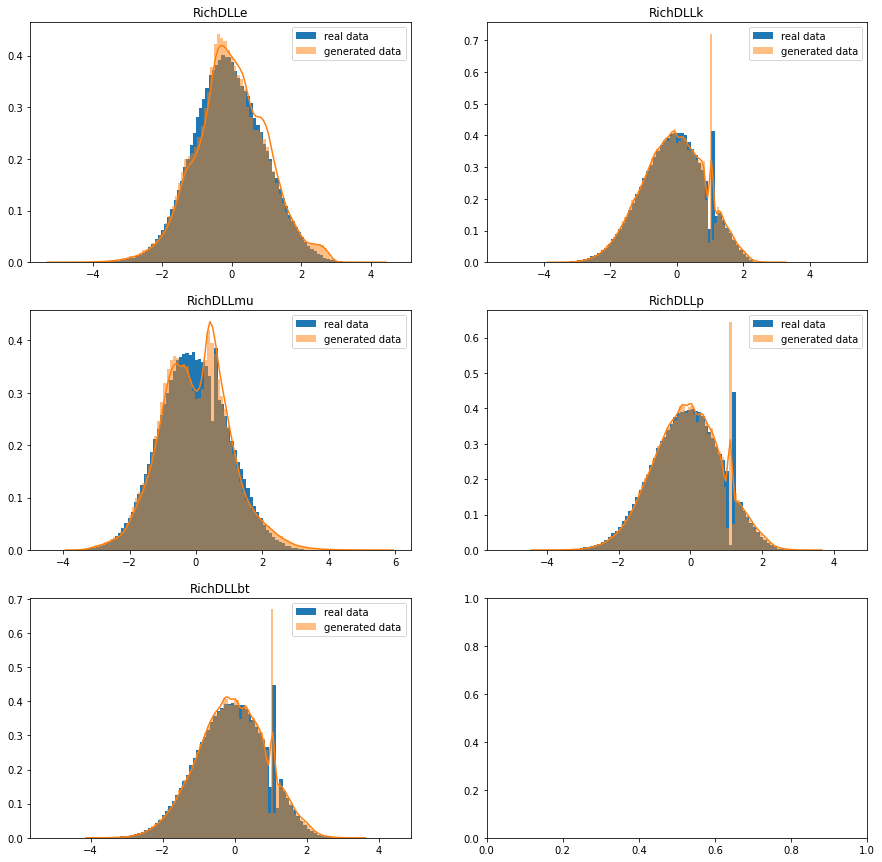

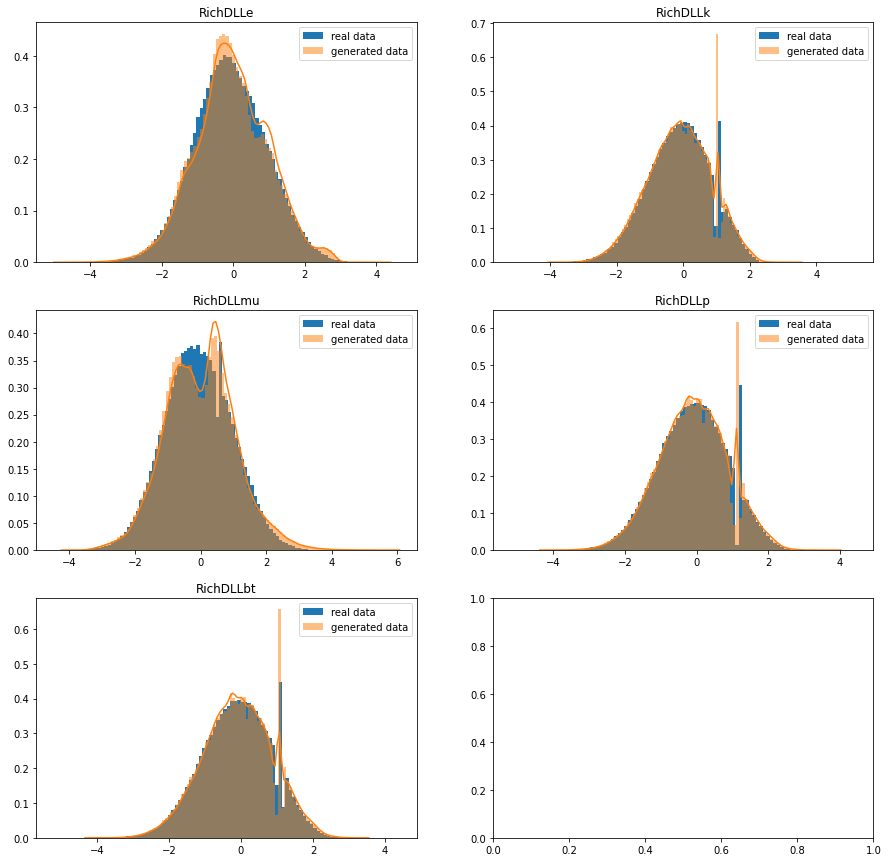

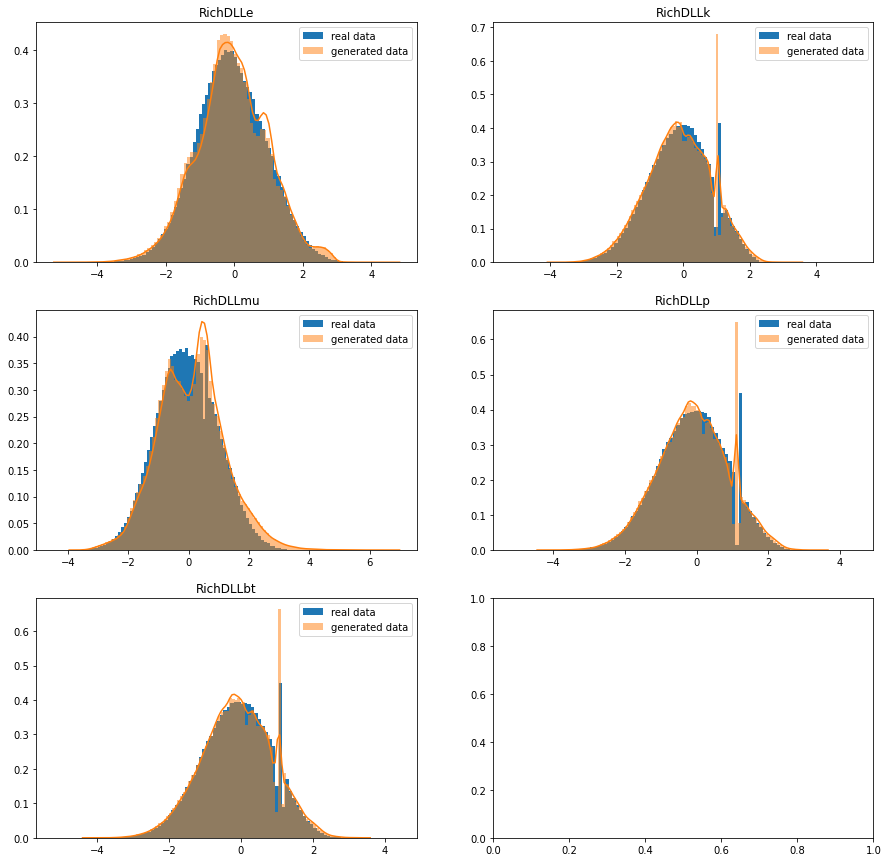

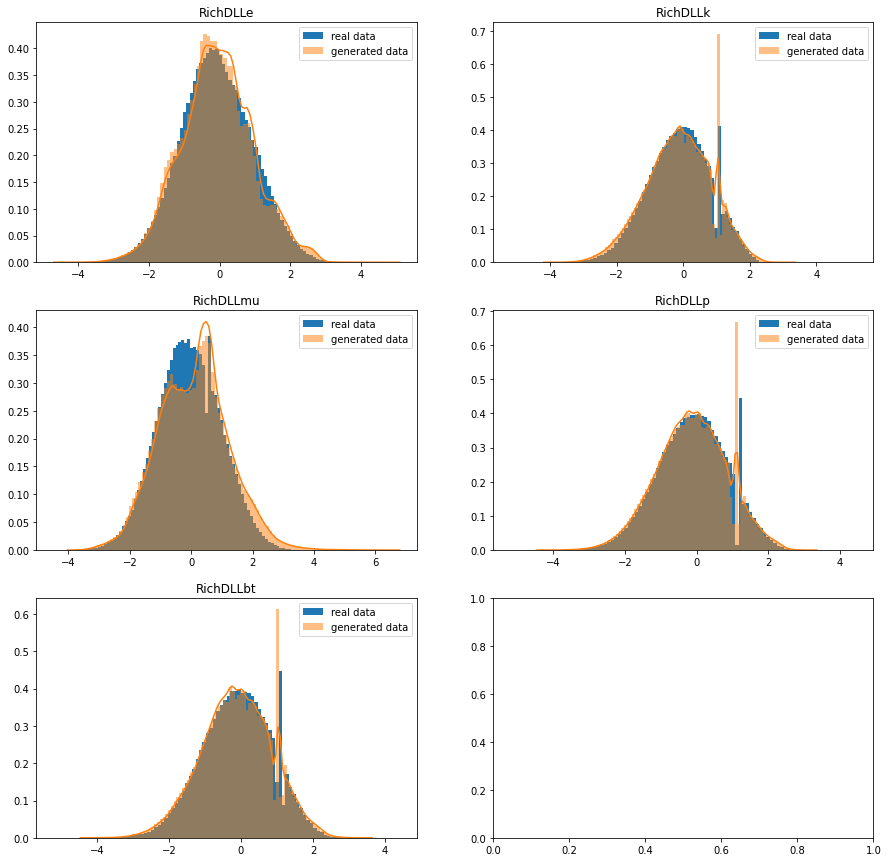

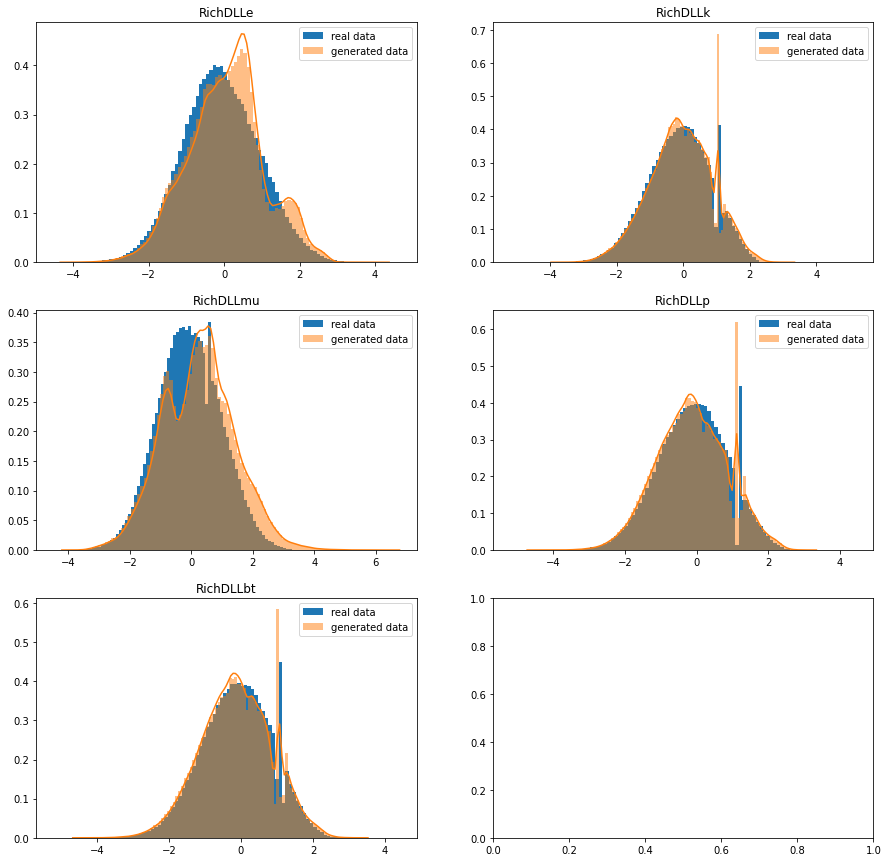

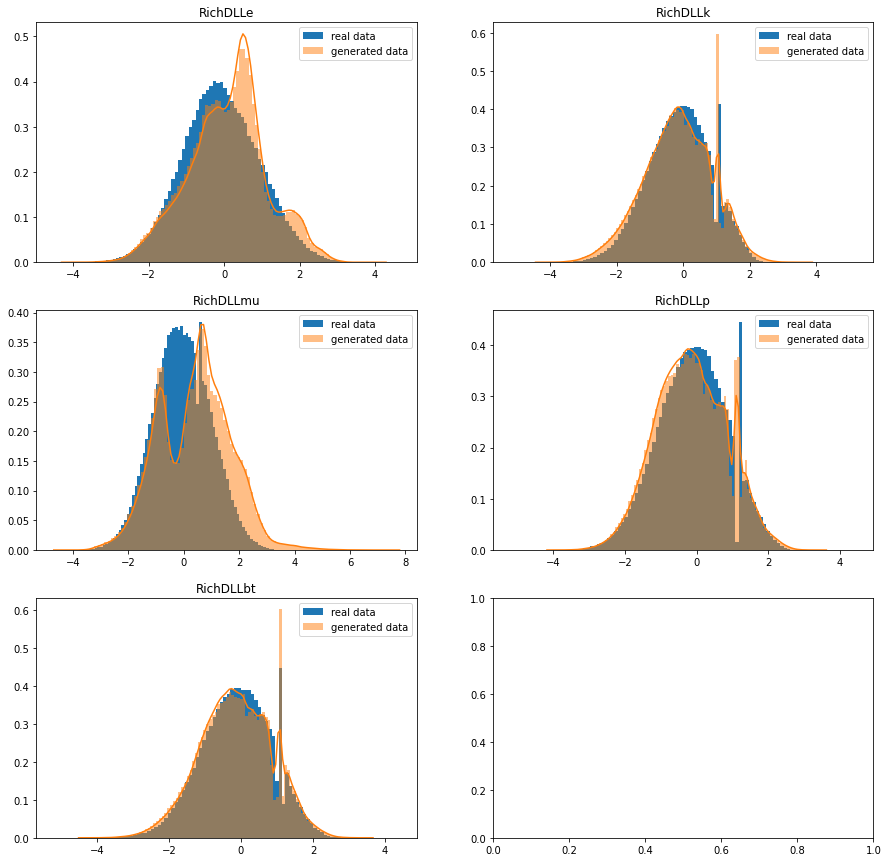

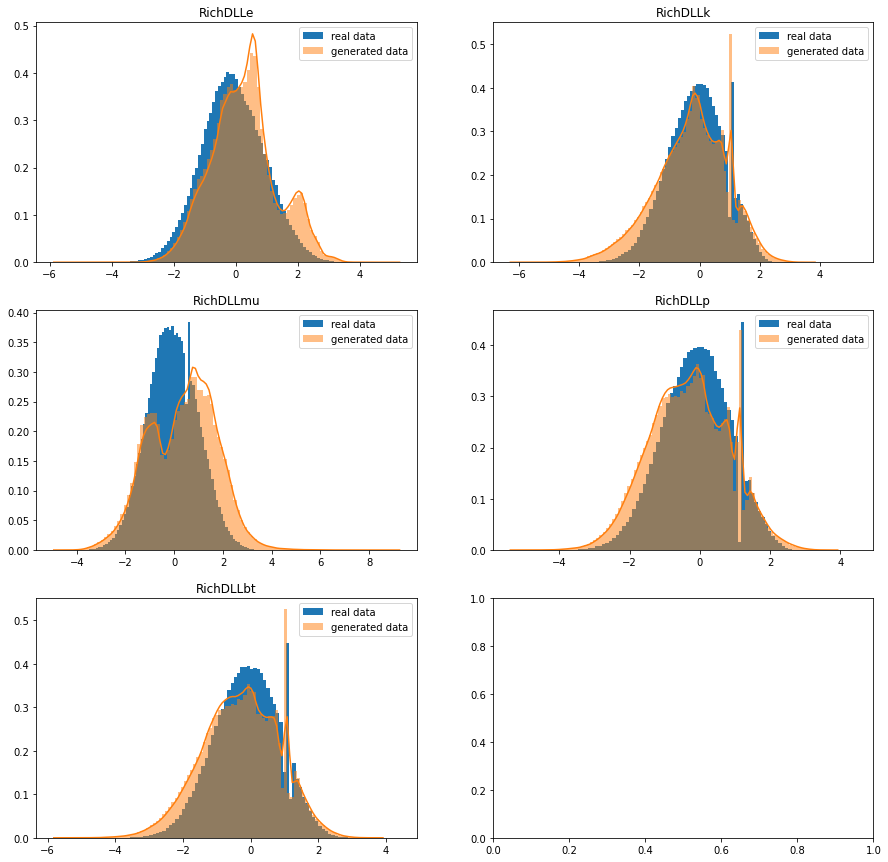

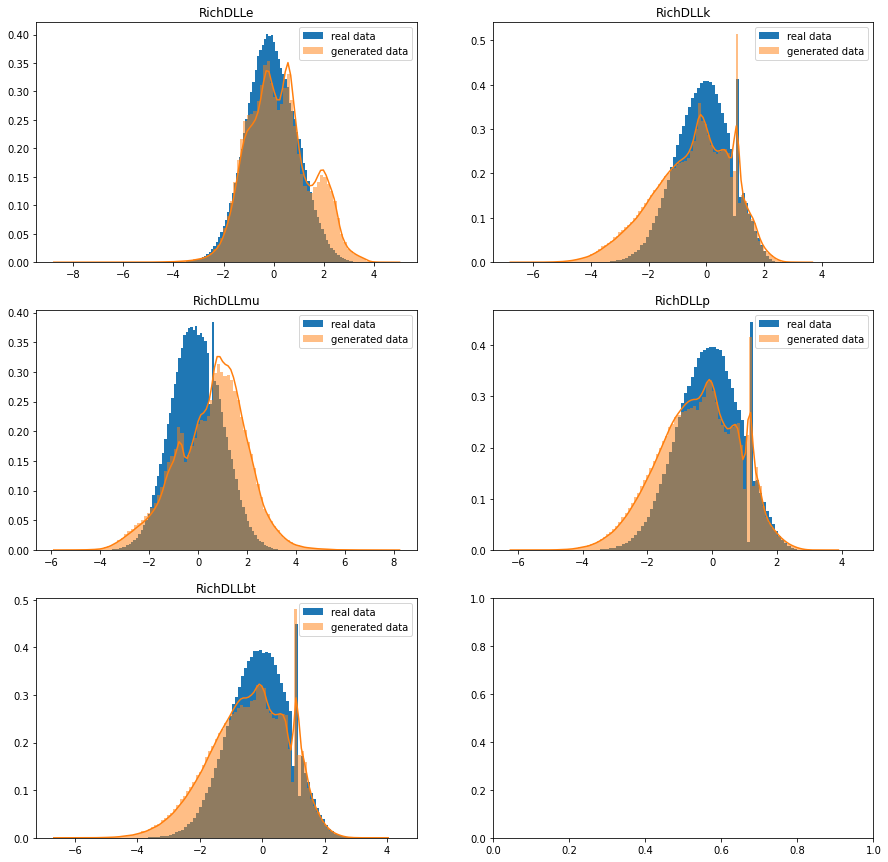

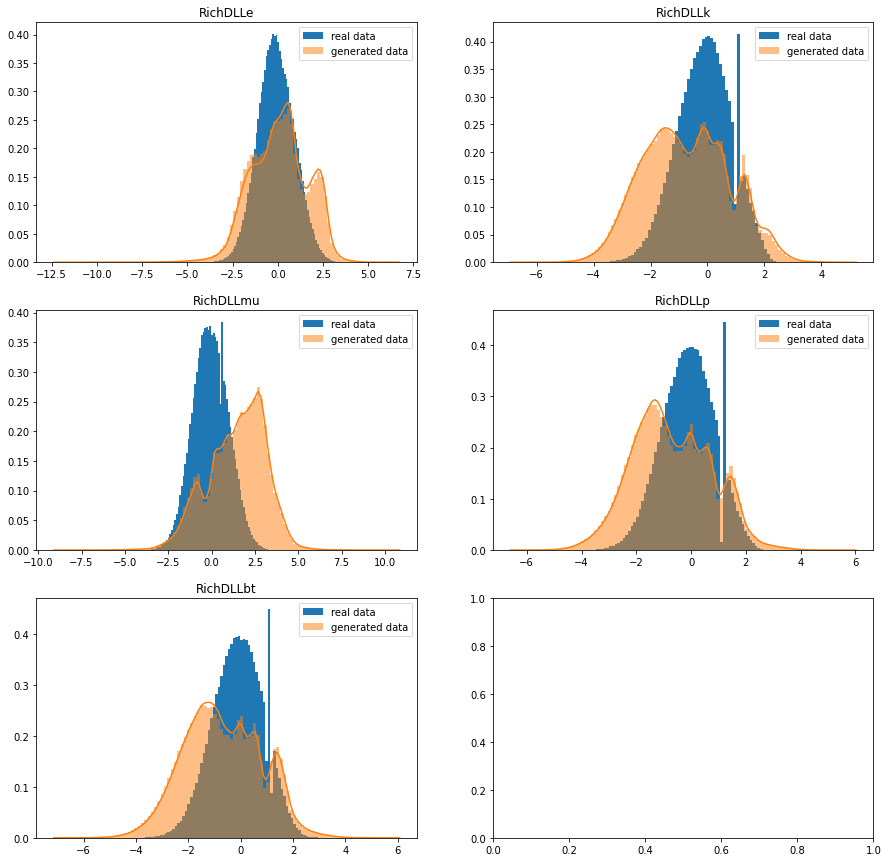

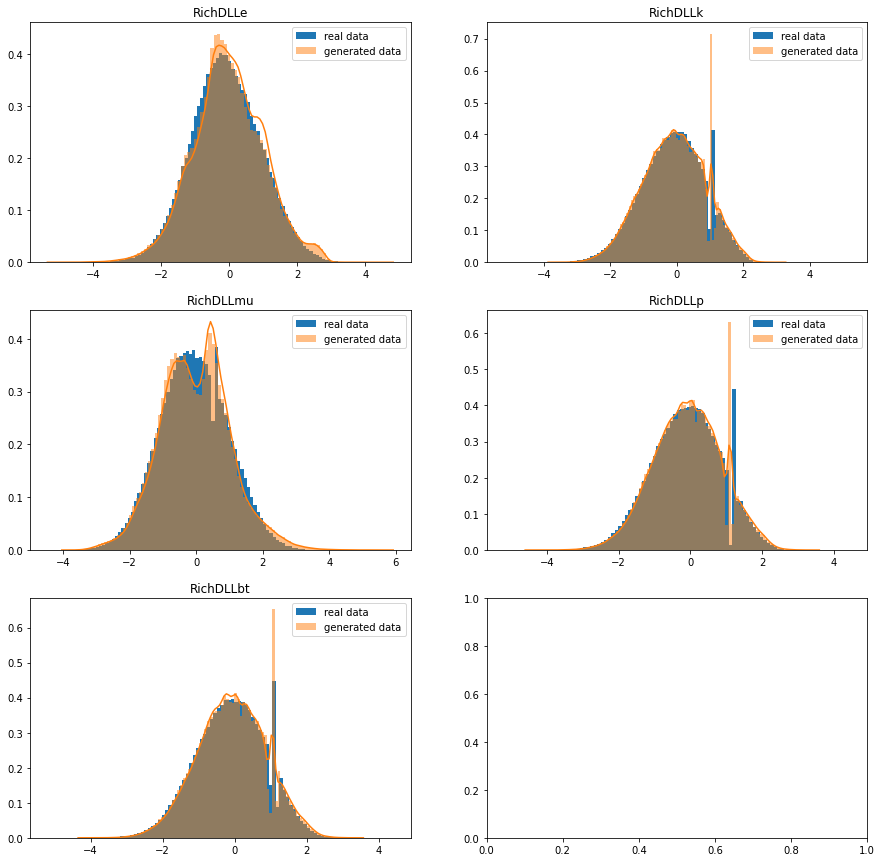

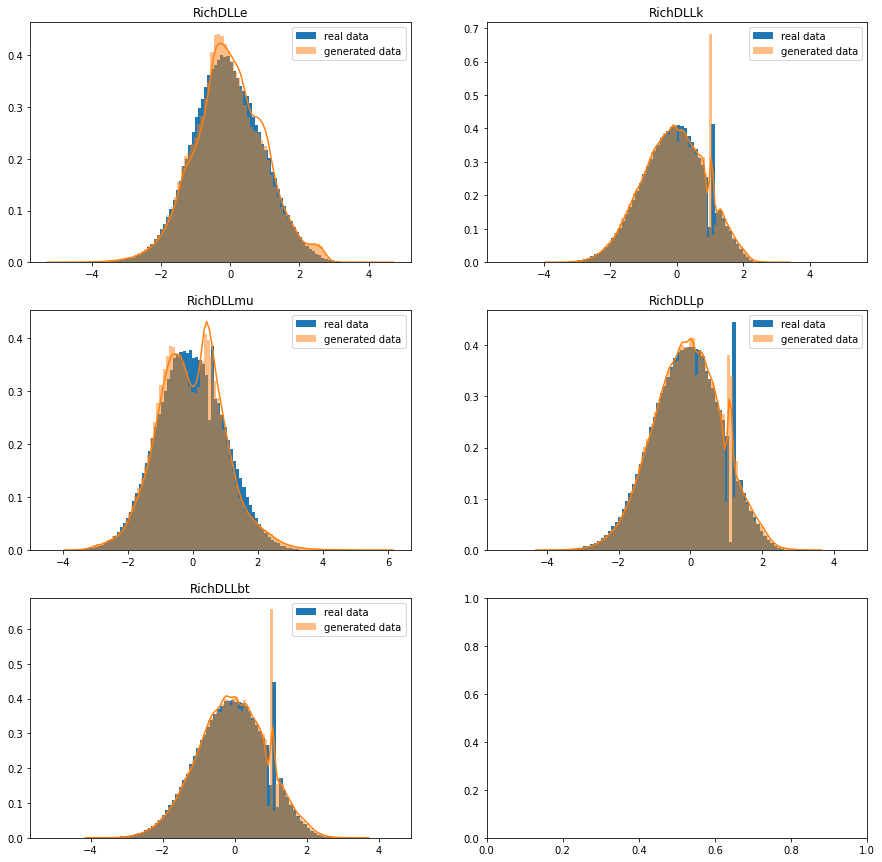

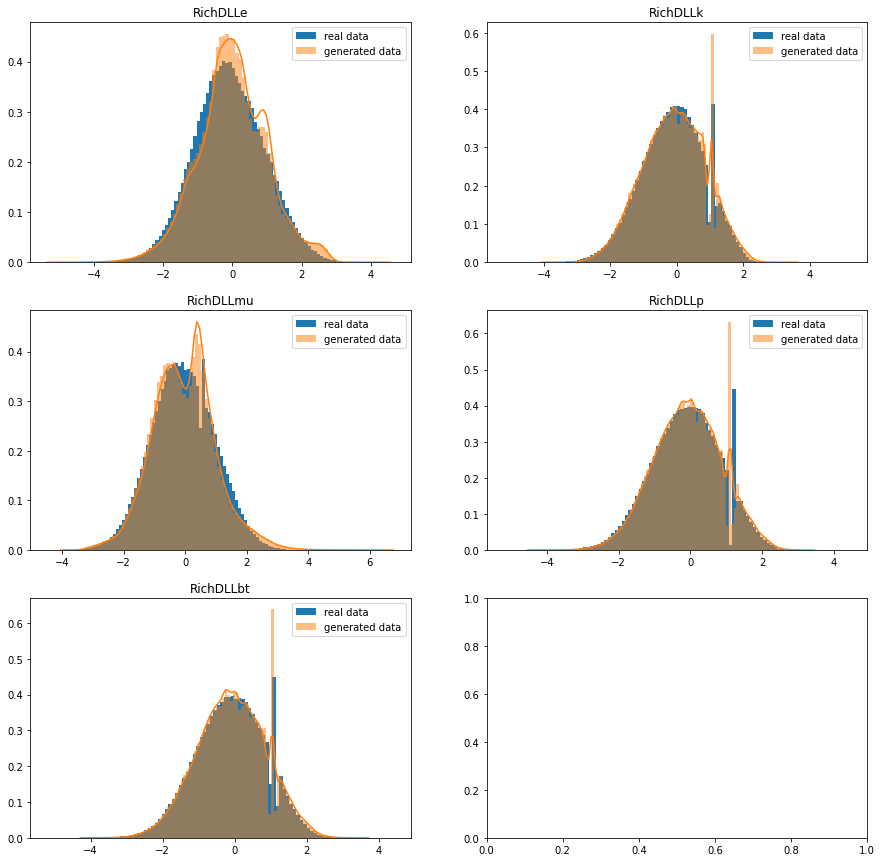

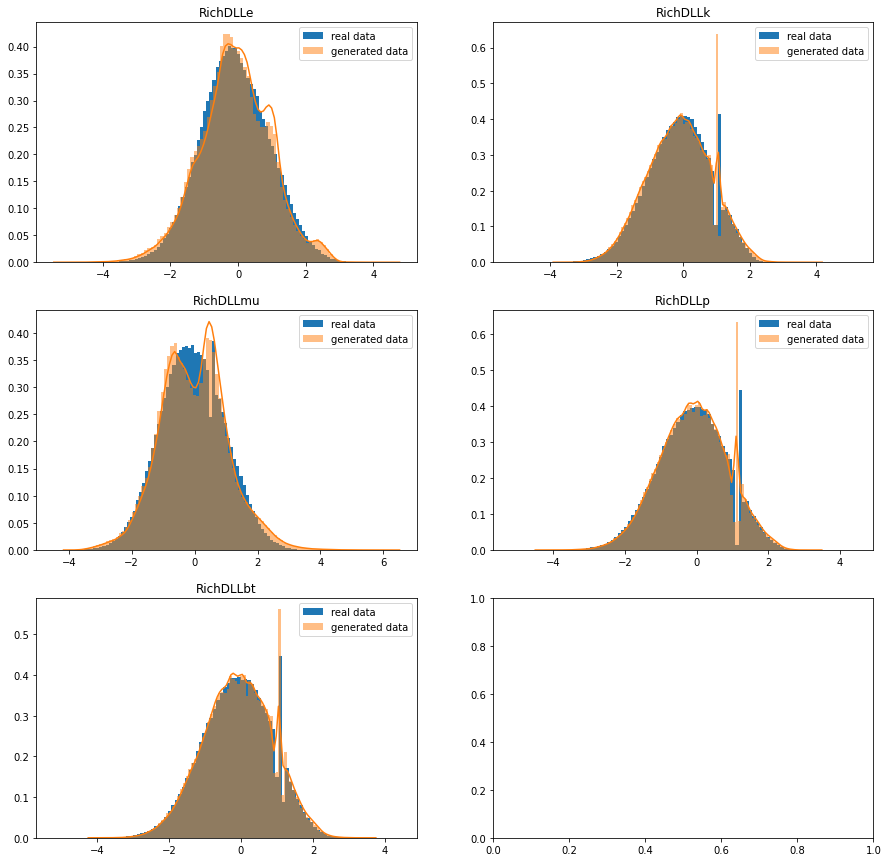

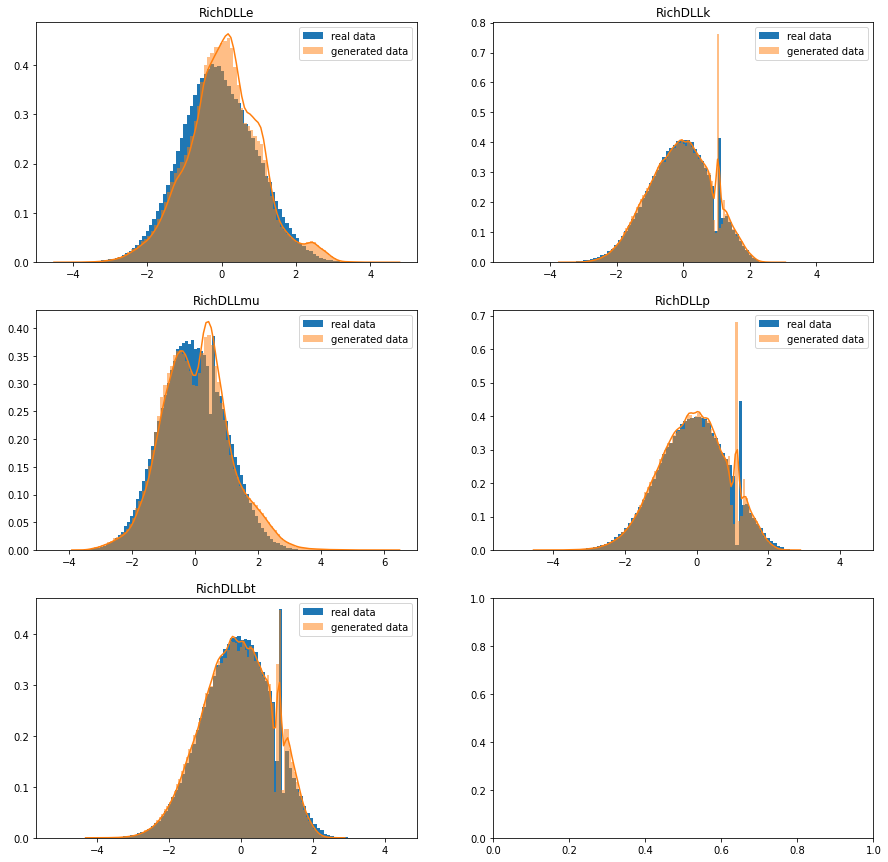

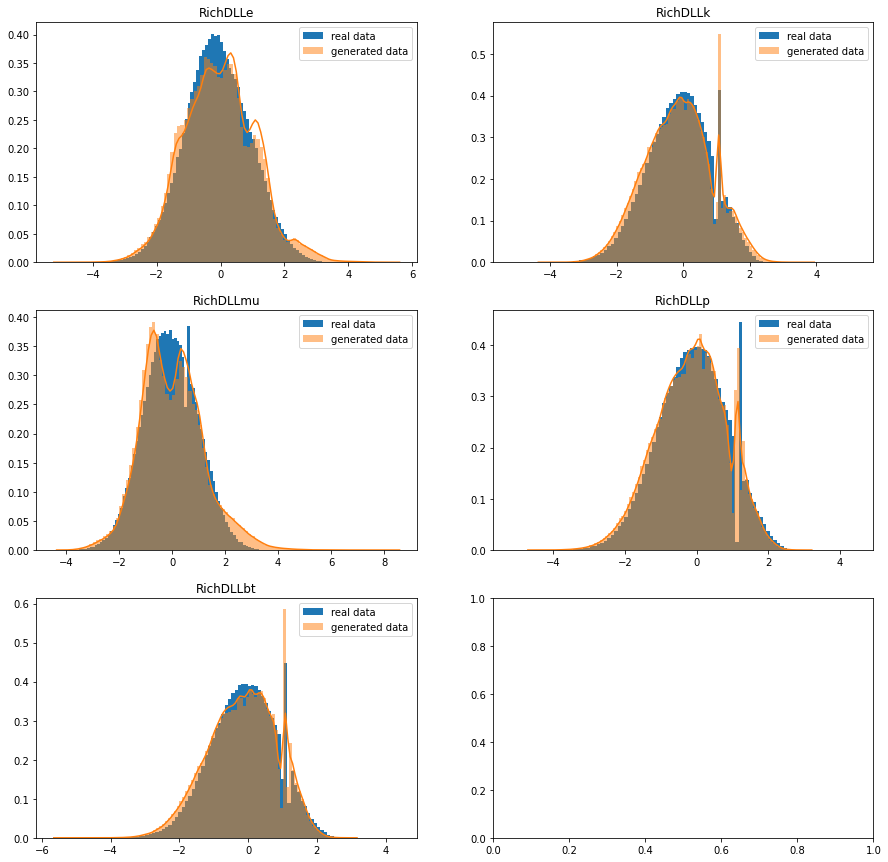

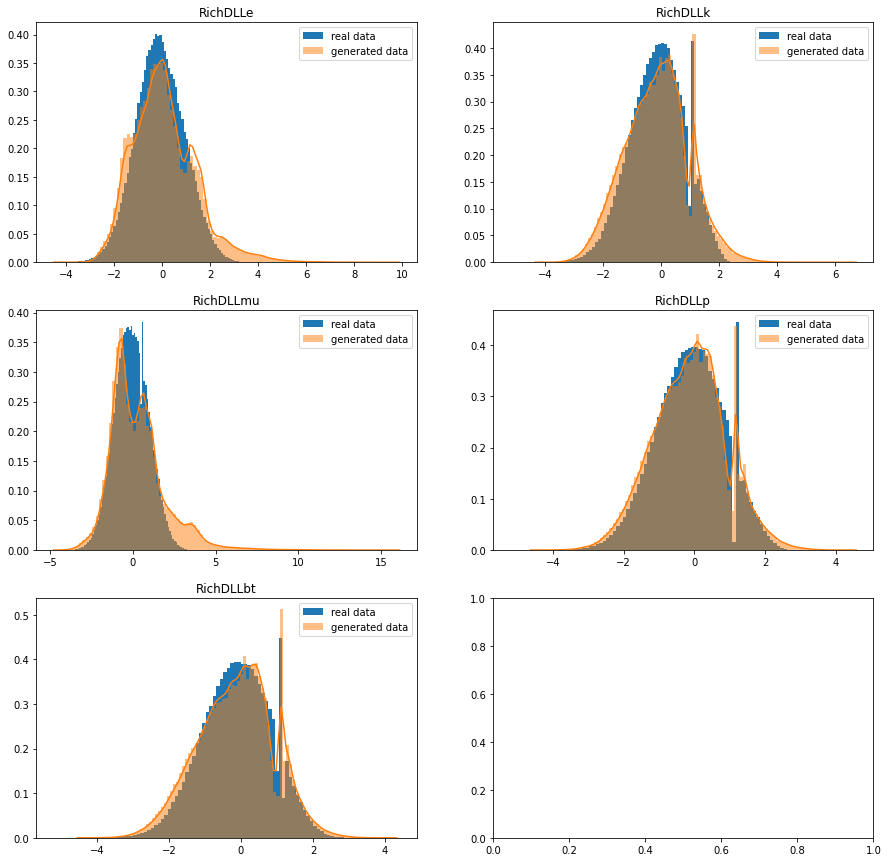

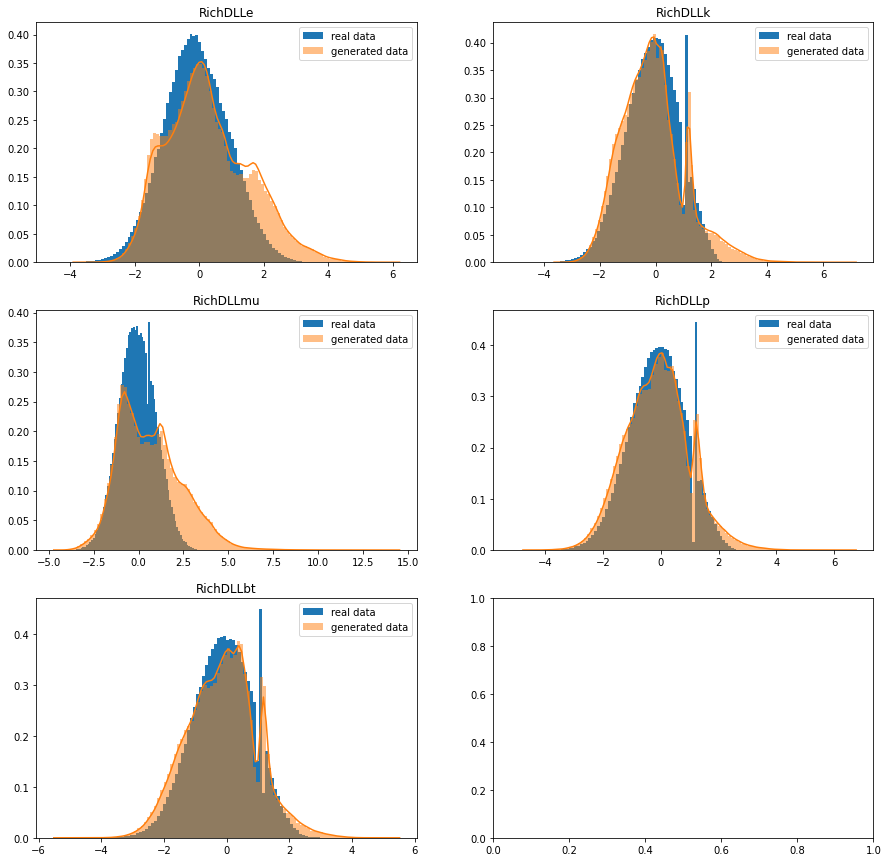

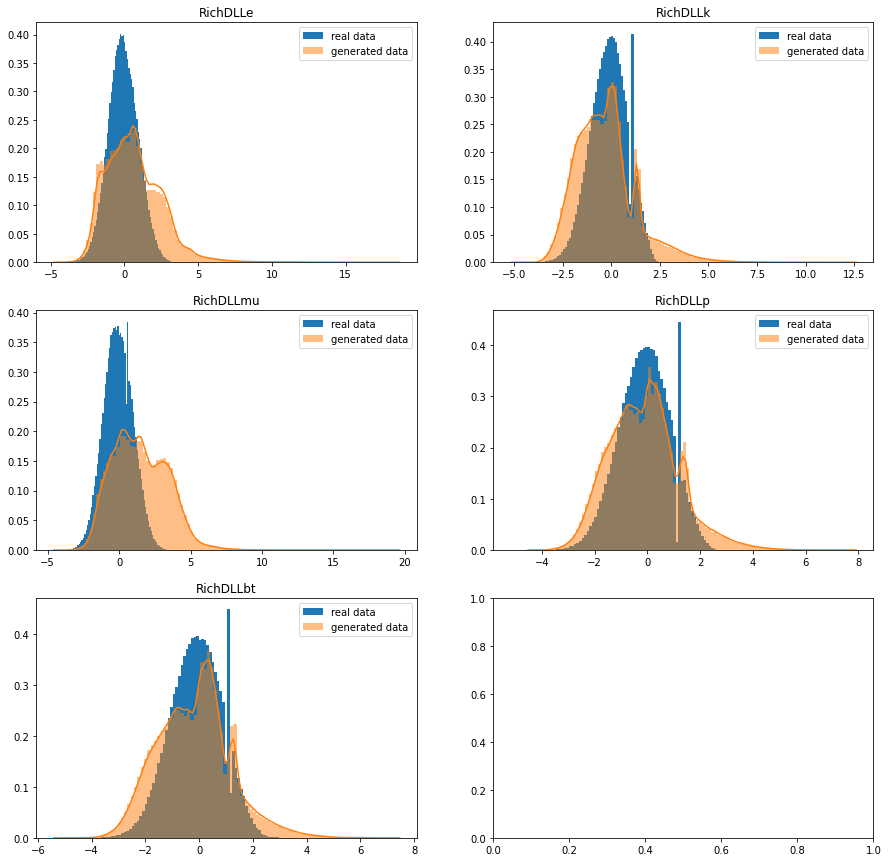

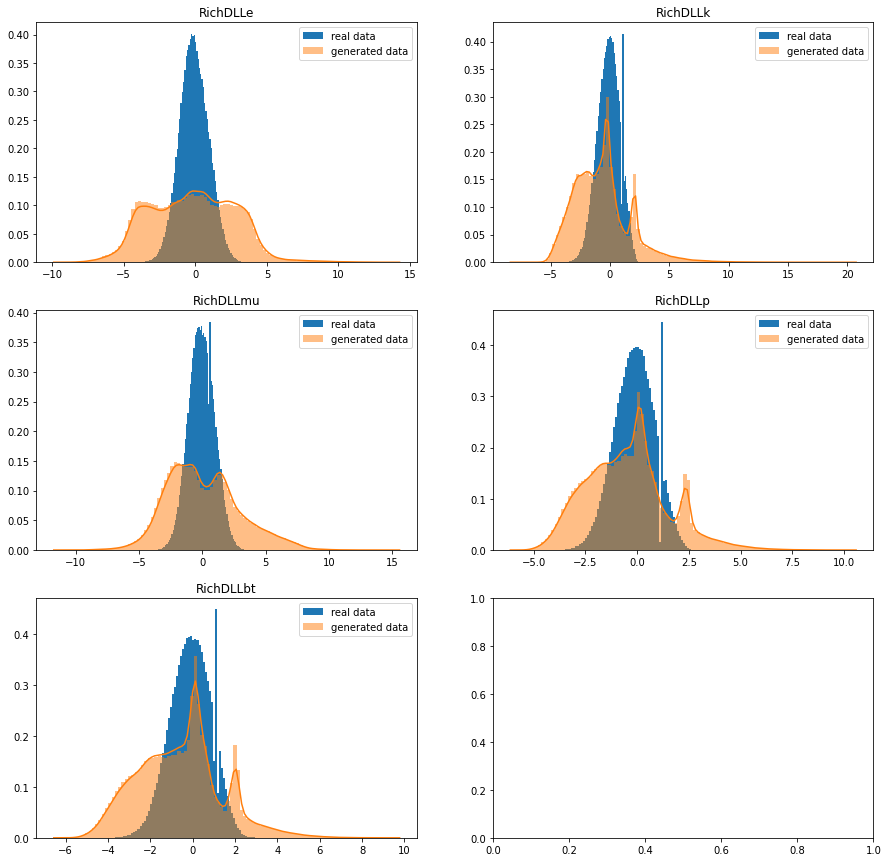

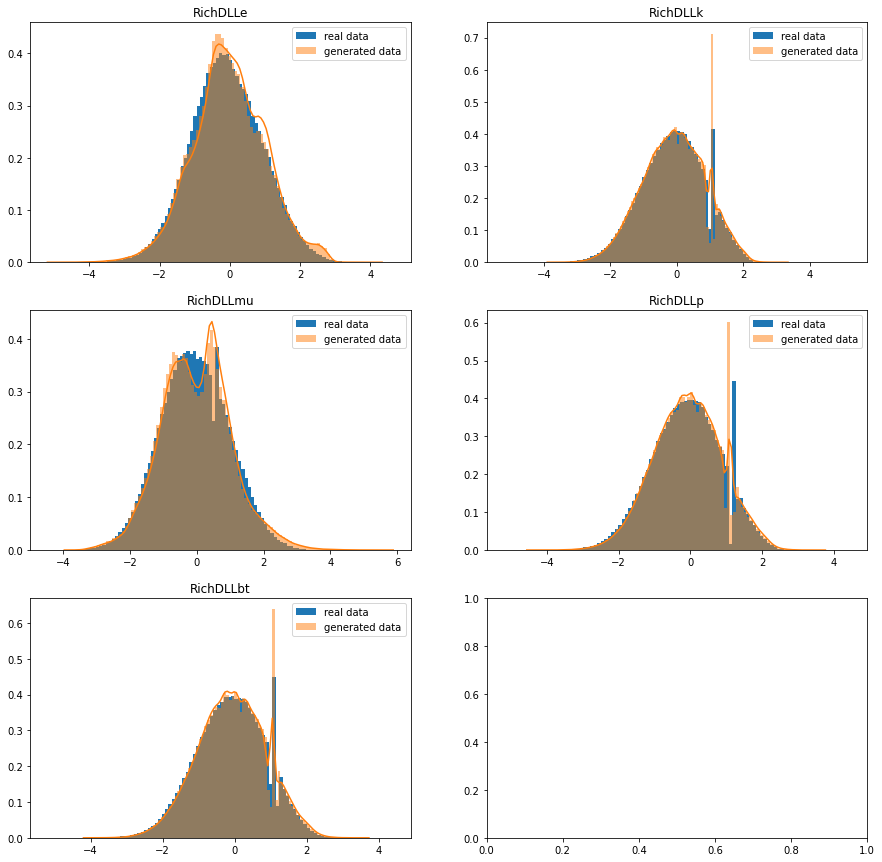

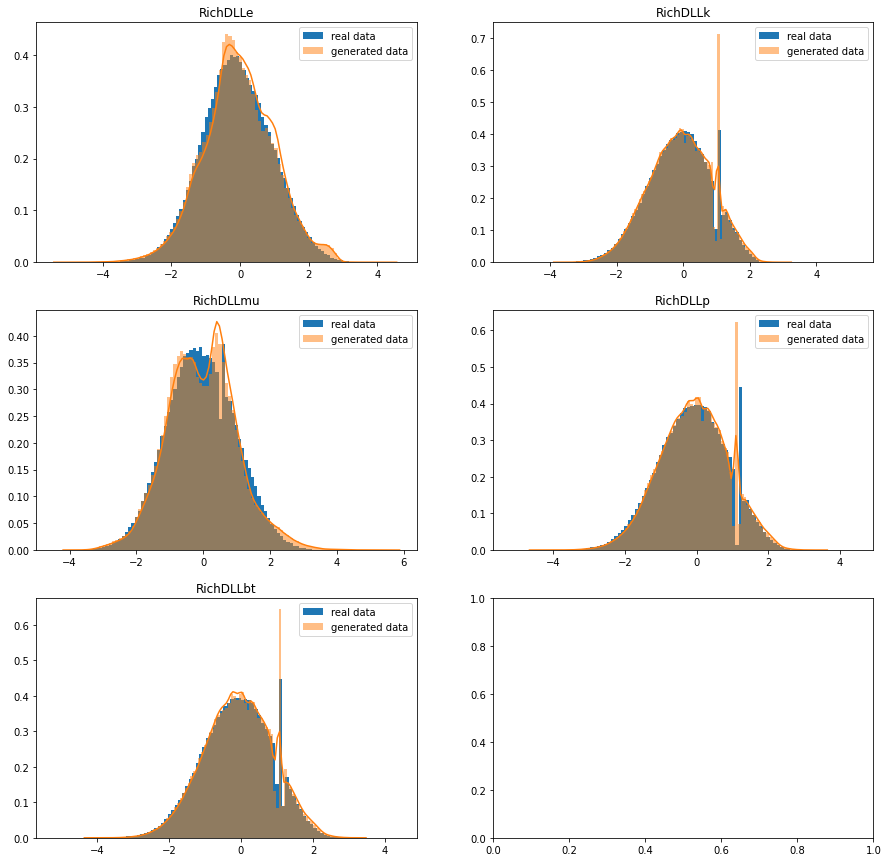

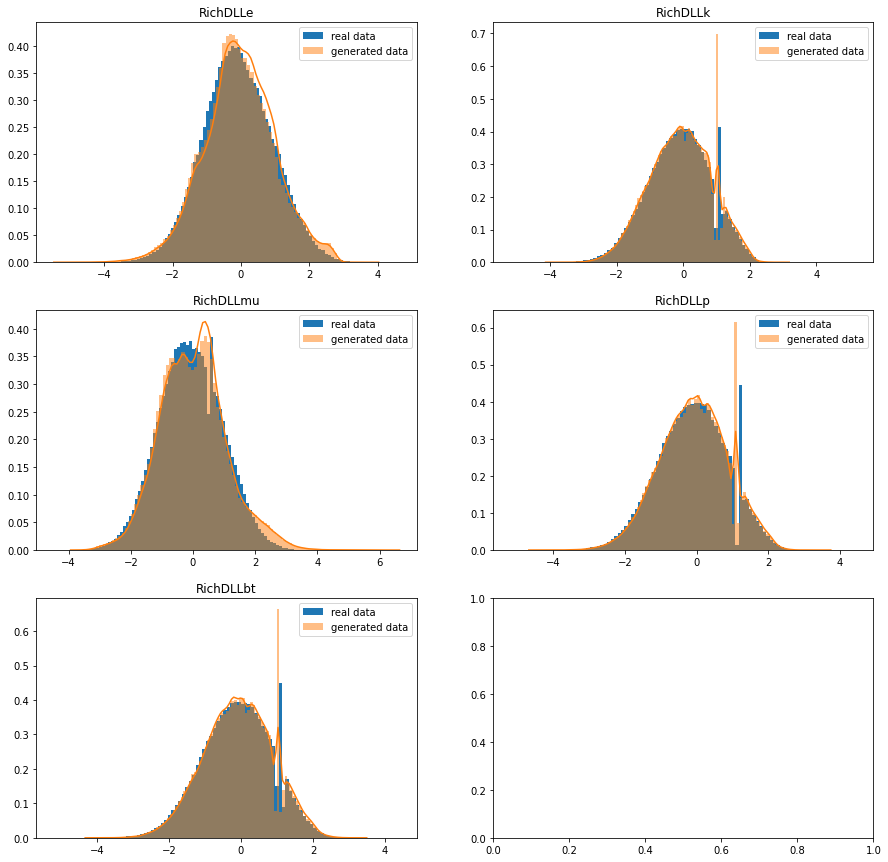

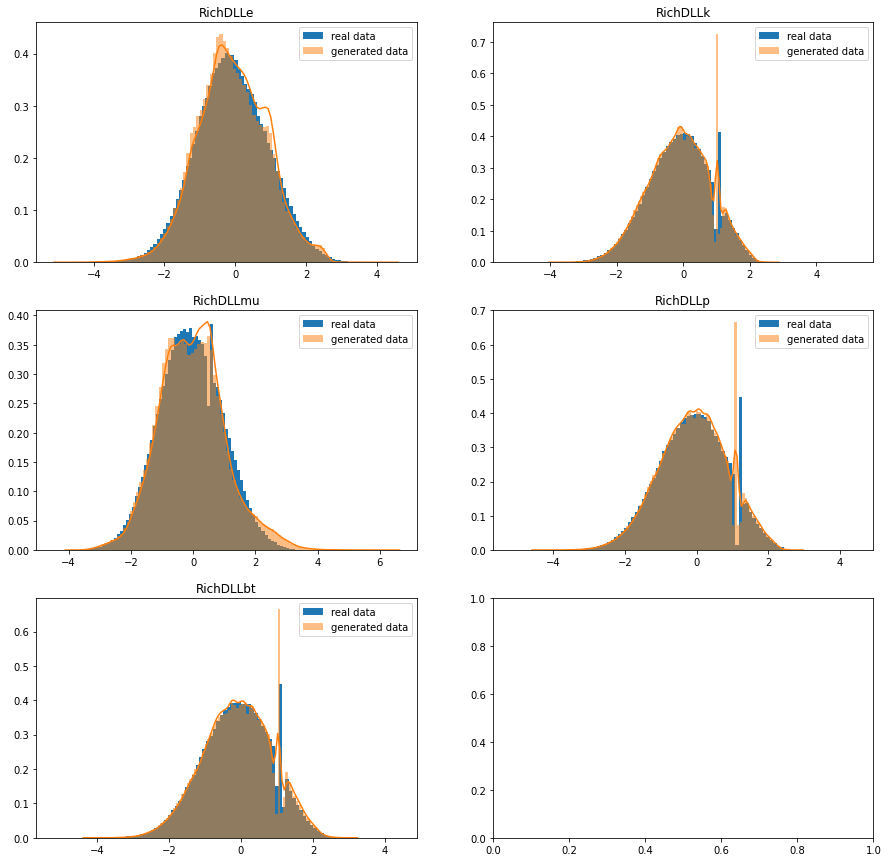

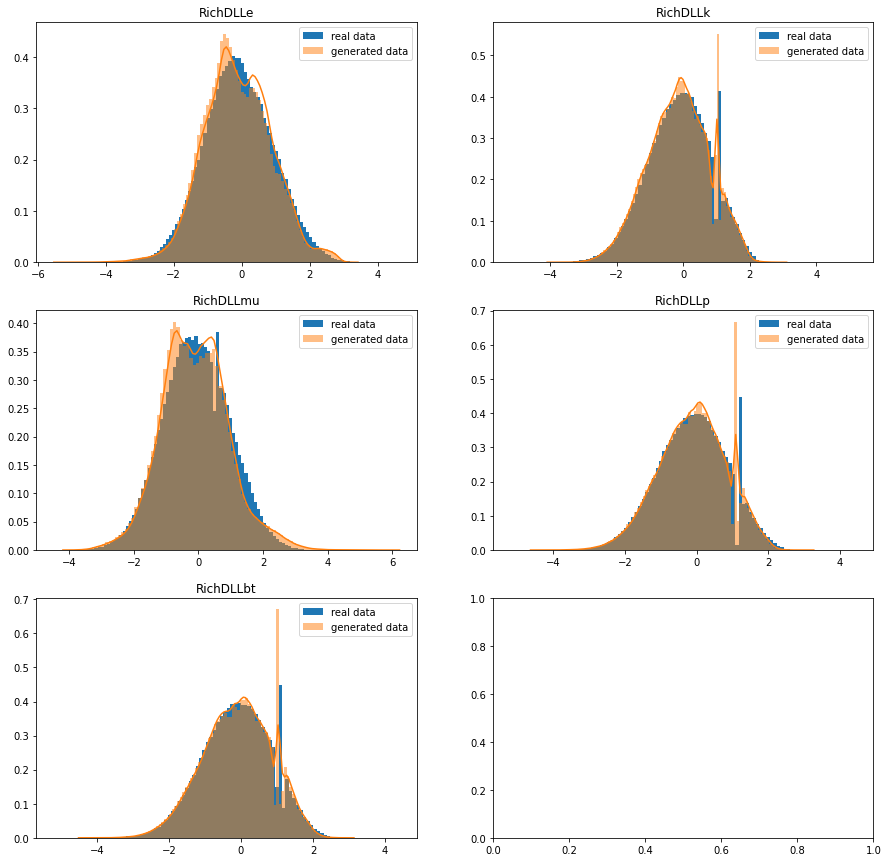

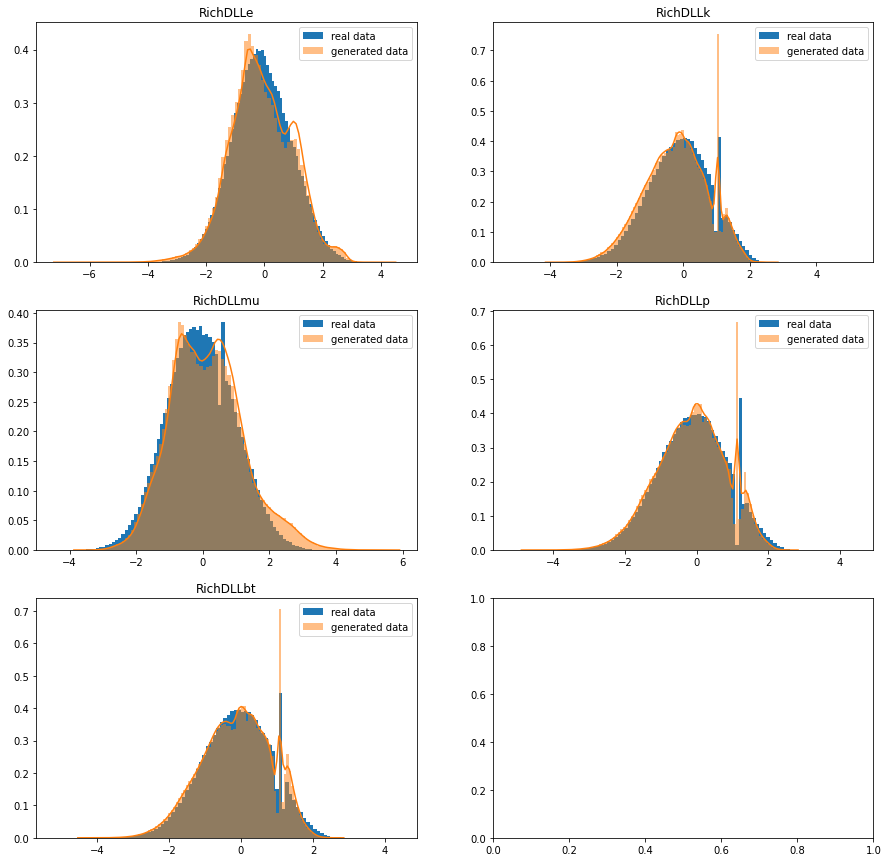

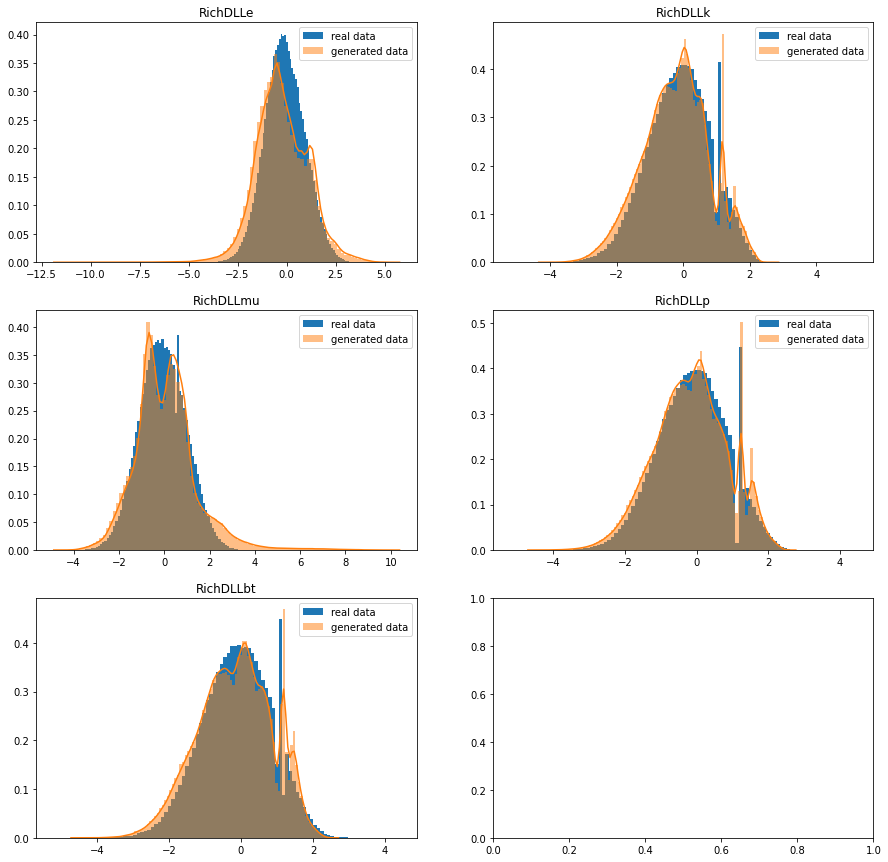

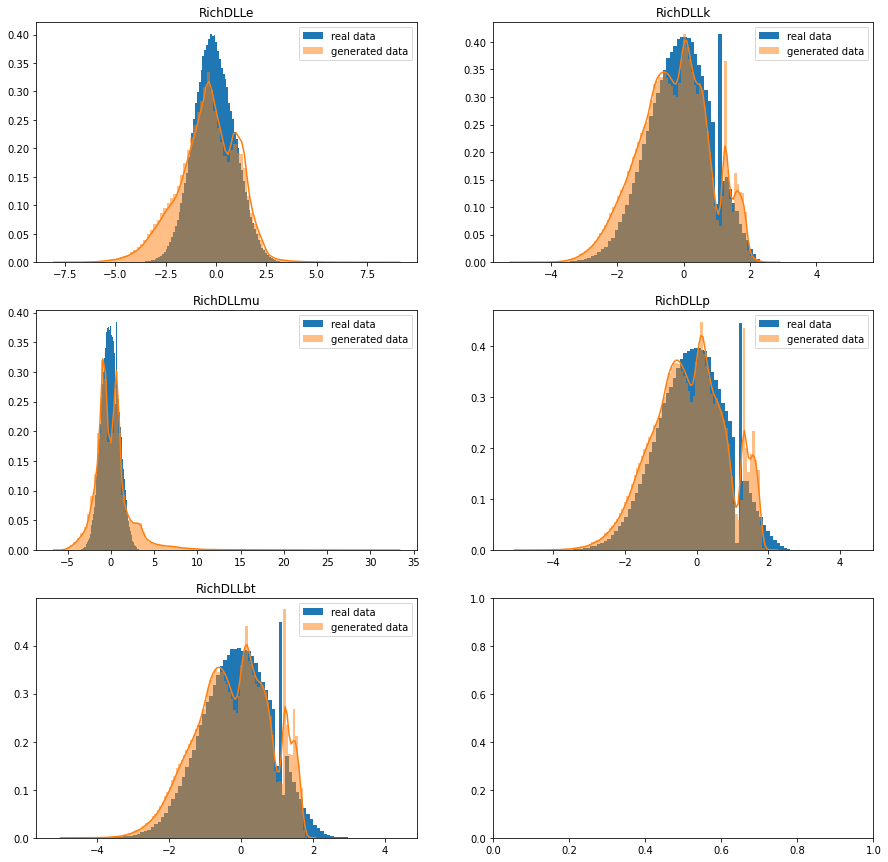

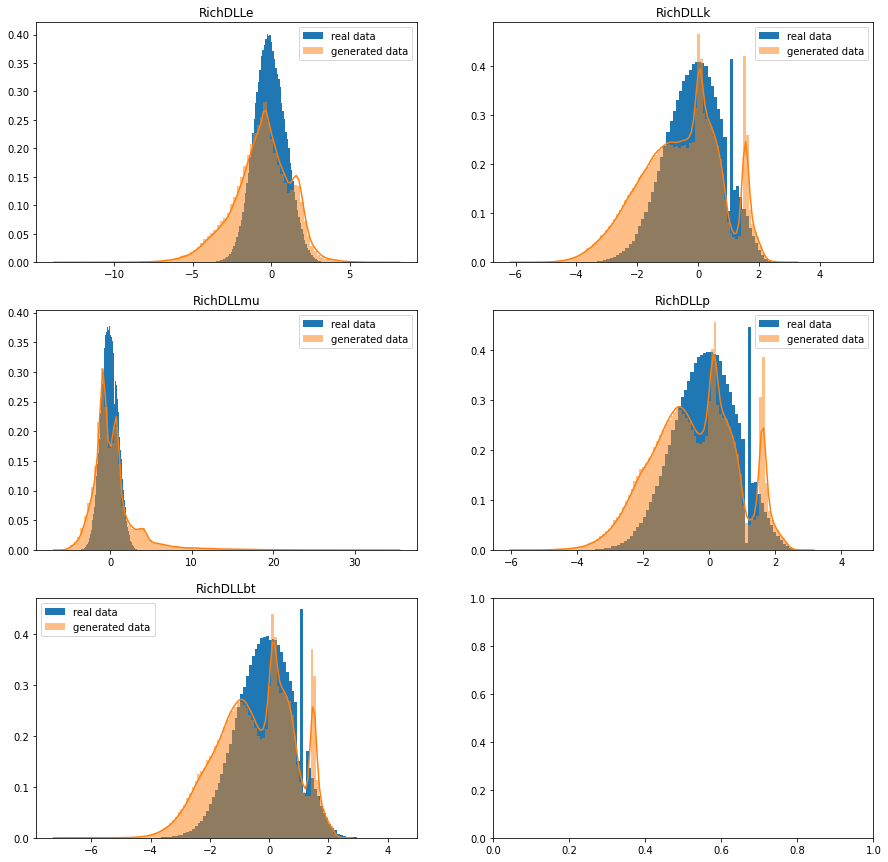

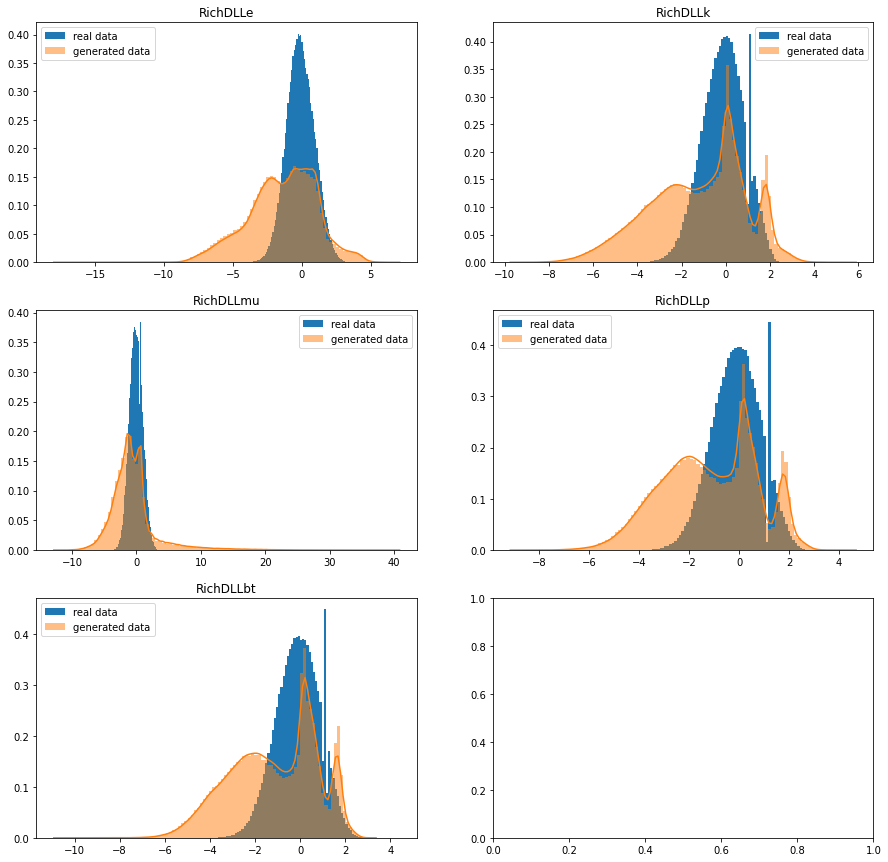

In [12]:
def layer_pruning(layer_number):
    pruning_metrics = {}
    for prune_amount in tqdm(range(0, 100, 10)):
        generator = copy.deepcopy(netG)
        pruning_metrics[prune_amount] = {}
        
        hidden_layer = 0
        for layer in generator.layers:
            if isinstance(layer, torch.nn.Sequential):
                if hidden_layer == layer_number:
                    linear_layer = layer[0]
                    prune.l1_unstructured(linear_layer, name='weight_orig', amount=prune_amount / 100)
                    prune.remove(linear_layer, 'weight_orig')
                hidden_layer += 1

        dlls, generated, weights, features = generate(generator)
        hists.plot_1d_hist(dlls, generated, hist_kws={'weights': weights})
        plt.savefig(f'layer-{layer_number}-{prune_amount}.png')

        # kolmogorov-smirnov
        ks_metrics = []
        for i in range(5):
            ks_metrics.append(kolmogorov_smirnov.ks_2samp_w(dlls[:, i], generated[:, i], weights, weights))
        pruning_metrics[prune_amount]['ks'] = ks_metrics

        # roc auc
        pruning_metrics[prune_amount]['auc'] = classification.calculate_rocauc(config, pd.DataFrame(features, columns=['a', 'b', 'c']), pd.DataFrame(dlls), pd.DataFrame(generated), weights)
    return pruning_metrics
        
# get metrics of different pruning functions
pruning_metrics = []
for i in range(5):
    pruning_metrics.append(layer_pruning(i))

In [13]:
pruning_metrics

[{0: {'ks': [0.013727307, 0.035369635, 0.01730138, 0.031742573, 0.031645298],
   'auc': (0.8312287465585416, 0.8303501101544138)},
  10: {'ks': [0.012442529, 0.035028517, 0.019097596, 0.030399323, 0.03073734],
   'auc': (0.8285132466392909, 0.8281011323045909)},
  20: {'ks': [0.01579994, 0.03533739, 0.020650178, 0.030471265, 0.03080678],
   'auc': (0.8294201768712688, 0.8288827885094799)},
  30: {'ks': [0.01169616, 0.035403788, 0.018304408, 0.030805111, 0.031554937],
   'auc': (0.8244654555404974, 0.8251970396389084)},
  40: {'ks': [0.022126853, 0.035420418, 0.01939118, 0.030233026, 0.030163229],
   'auc': (0.8101066138769735, 0.8118791060387038)},
  50: {'ks': [0.016965032, 0.03684175, 0.035905957, 0.032083333, 0.03275925],
   'auc': (0.8092892274945055, 0.8109134328163807)},
  60: {'ks': [0.043756485, 0.041293204, 0.055202603, 0.03754592, 0.03870696],
   'auc': (0.7841901812017426, 0.7874015752040443)},
  70: {'ks': [0.081276596, 0.051687658, 0.060078382, 0.04846555, 0.05287212],
   

In [19]:
labels = ['1', '2', '3', '4', '5']

aucs = [[] for _ in labels]
ks_min = [[] for _ in labels]
ks_max = [[] for _ in labels]
ks_mean = [[] for _ in labels]
for idx, m in enumerate(pruning_metrics):
    for k, v in m.items():
        aucs[idx].append(v['auc'][0]) # get only weighed auc
        ks_mean[idx].append(np.mean(v['ks']))
        ks_max[idx].append(np.max(v['ks']))
        ks_min[idx].append(np.min(v['ks']))

<Figure size 432x288 with 0 Axes>

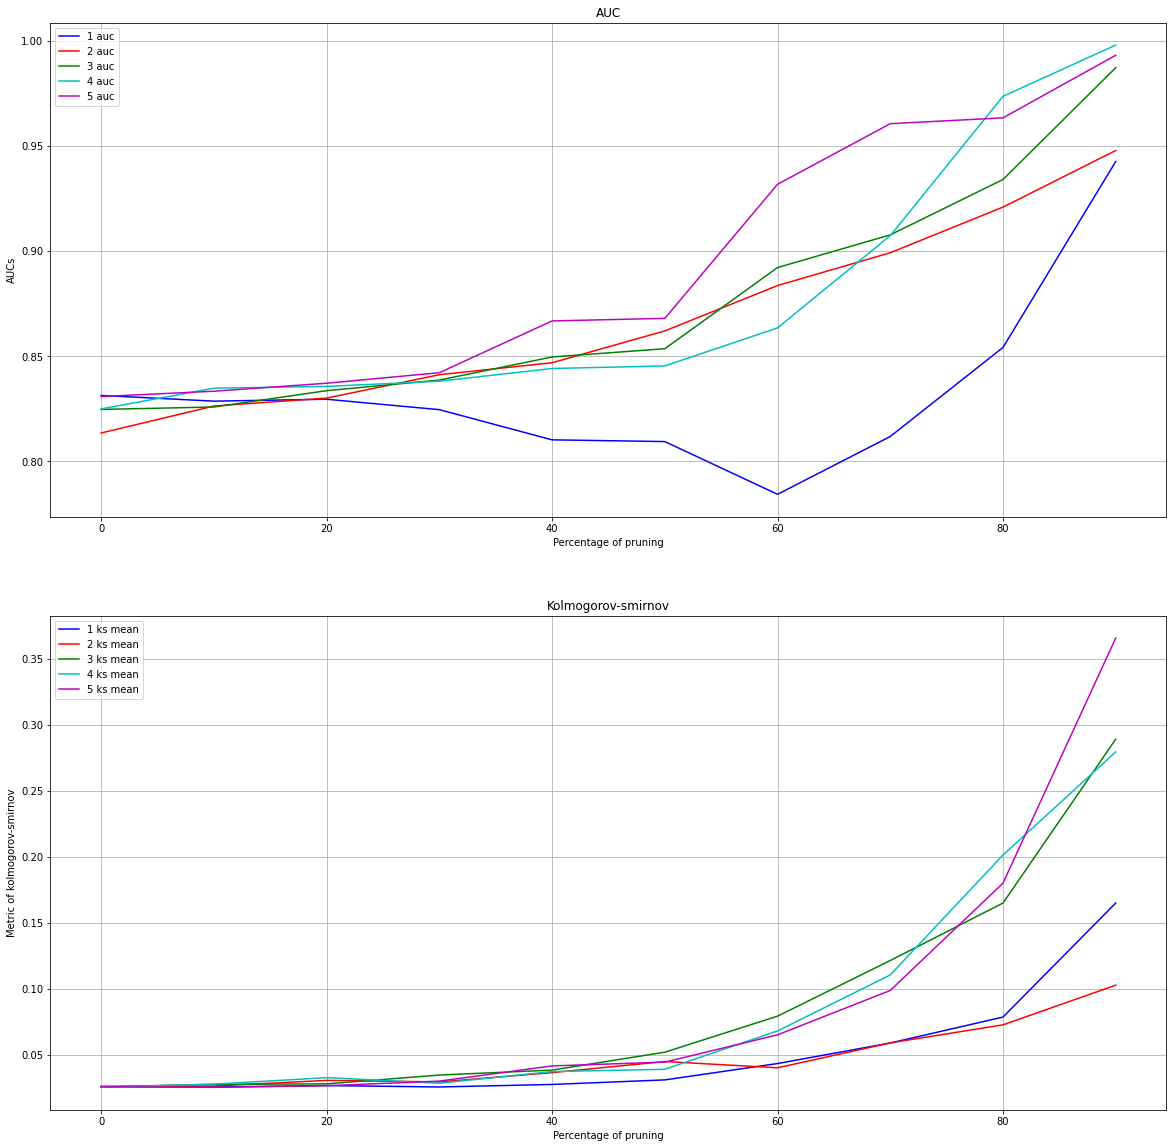

In [24]:
fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

x = list(range(0, 100, 10))
colors = ['b', 'r', 'g', 'c', 'm']

for idx, i in enumerate(labels):
    ax1.plot(x, aucs[idx], label=i + ' auc', color=colors[idx])

ax1.legend()
ax1.set_xlabel('Percentage of pruning')
ax1.set_ylabel('AUCs')
ax1.set_title('AUC')
ax1.grid()


for idx, i in enumerate(labels):
    ax2.plot(x, ks_mean[idx], label=i + ' ks mean', color=colors[idx])
#     ax2.plot(x, ks_min[idx], label=i + ' ks min', color=colors[idx], linestyle='--')
#     ax2.plot(x, ks_max[idx], label=i + ' ks max', color=colors[idx], linestyle='--')

ax2.legend()
ax2.set_xlabel('Percentage of pruning')
ax2.set_ylabel('Metric of kolmogorov-smirnov')
ax2.set_title('Kolmogorov-smirnov')
ax2.grid();

### Combination of two aproaches

In [13]:
from core.metrics import classification, kolmogorov_smirnov
from core.metrics import hists

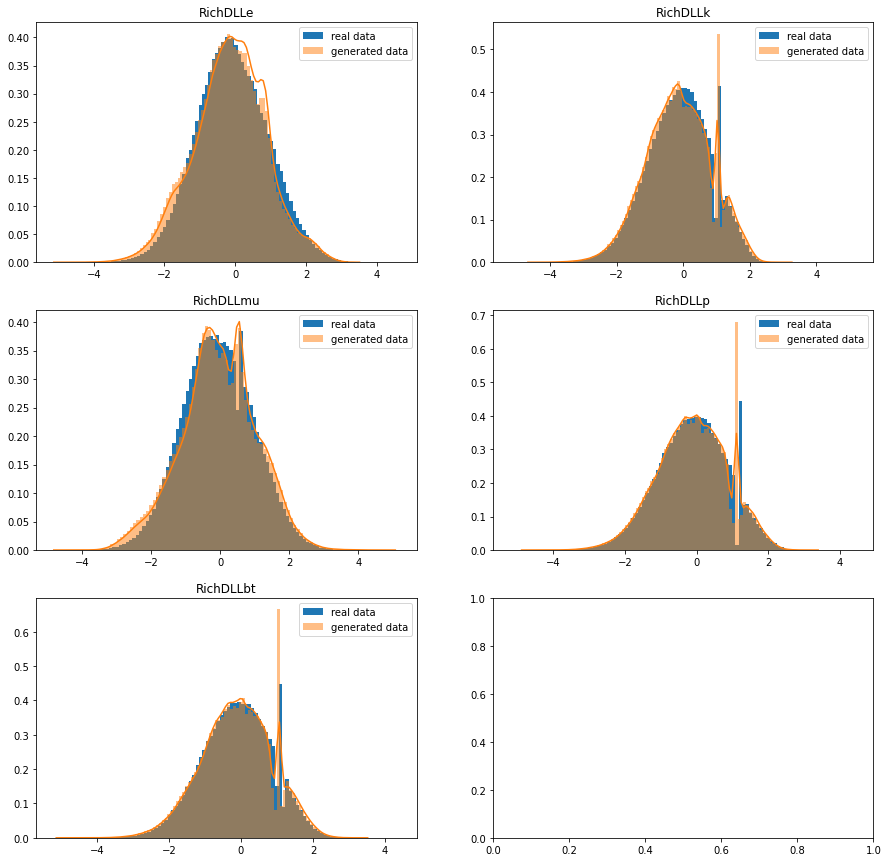

In [12]:
pruning_metrics = {}
generator = copy.deepcopy(netG)

hidden_layer = 0
for layer in generator.layers:
    if isinstance(layer, torch.nn.Sequential):
        linear_layer = layer[0]
        if hidden_layer == 0:
            prune.l1_unstructured(linear_layer, name='weight_orig', amount=0.2)
        else:
            prune.l1_unstructured(linear_layer, name='weight_orig', amount=0.2)
        prune.remove(linear_layer, 'weight_orig')
        hidden_layer += 1

dlls, generated, weights, features = generate(generator)
hists.plot_1d_hist(dlls, generated, hist_kws={'weights': weights})

# kolmogorov-smirnov
ks_metrics = []
for i in range(5):
    ks_metrics.append(kolmogorov_smirnov.ks_2samp_w(dlls[:, i], generated[:, i], weights, weights))
pruning_metrics['ks'] = ks_metrics

# roc auc
pruning_metrics['auc'] = classification.calculate_rocauc(config, pd.DataFrame(features, columns=['a', 'b', 'c']), pd.DataFrame(dlls), pd.DataFrame(generated), weights)

In [12]:
from collections import OrderedDict

class LinearMasked(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(LinearMasked, self).__init__(in_features, out_features, bias)
        self.mask_flag = False

    def set_mask(self, mask):
        self.mask = Variable(mask, requires_grad=False, volatile=False)
        self.weight.data = self.weight.data * self.mask.data
        self.mask_flag = True

    def get_mask(self):
        print(self.mask_flag)
        return self.mask

    def forward(self, x):
        if self.mask_flag:
            weight = self.weight * self.mask
            return F.linear(x, weight, self.bias)
        else:
            return F.linear(x, self.weight, self.bias)
        

def _linear_flops(module, activation):
    # Auxiliary func to use abstract flop computation
    return dense_flops(module.in_features, module.out_features)


def flops(model, input):
    """Compute Multiply-add FLOPs estimate from model
    Arguments:
        model {torch.nn.Module} -- Module to compute flops for
        input {torch.Tensor} -- Input tensor needed for activations
    Returns:
        tuple:
        - int - Number of total FLOPs
        - int - Number of FLOPs related to nonzero parameters
    """
    FLOP_fn = {
        nn.Linear: _linear_flops,
        LinearMasked: _linear_flops,
    }

    total_flops = nonzero_flops = 0
    activations = get_activations(model, input)

    # The ones we need for backprop
    for m, (act, _) in activations.items():
        if m.__class__ in FLOP_fn:
            w = m.weight.detach().cpu().numpy().copy()
            module_flops = FLOP_fn[m.__class__](m, act)
            total_flops += module_flops
            # For our operations, all weights are symmetric so we can just
            # do simple rule of three for the estimation
            nonzero_flops += module_flops * nonzero(w).sum() / np.prod(w.shape)

    return total_flops, nonzero_flops


def get_activations(model, input):

    activations = OrderedDict()

    def store_activations(module, input, output):
        if isinstance(module, nn.ReLU):
            # TODO ResNet18 implementation reuses a
            # single ReLU layer?
            return
        assert module not in activations, f"{module} already in activations"
        # TODO [0] means first input, not all models have a single input
        activations[module] = (
            input[0].detach().cpu().numpy().copy(),
            output.detach().cpu().numpy().copy(),
        )

    fn, hooks = hook_applyfn(store_activations, model, forward=True)
    model.apply(fn)
    with torch.no_grad():
        model(input)

    for h in hooks:
        h.remove()

    return activations


def hook_applyfn(hook, model, forward=False, backward=False):
    """
    [description]
    Arguments:
        hook {[type]} -- [description]
        model {[type]} -- [description]
    Keyword Arguments:
        forward {bool} -- [description] (default: {False})
        backward {bool} -- [description] (default: {False})
    Returns:
        [type] -- [description]
    """
    assert forward ^ backward, "Either forward or backward must be True"
    hooks = []

    def register_hook(module):
        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not isinstance(module, nn.ModuleDict)
            and not (module == model)
        ):
            if forward:
                hooks.append(module.register_forward_hook(hook))
            if backward:
                hooks.append(module.register_backward_hook(hook))

    return register_hook, hooks


def dense_flops(in_neurons, out_neurons):
    """Compute the number of multiply-adds used by a Dense (Linear) layer"""
    return in_neurons * out_neurons


def nonzero(tensor):
    """Returns absolute number of values different from 0
    Arguments:
        tensor {numpy.ndarray} -- Array to compute over
    Returns:
        int -- Number of nonzero elements
    """
    return np.sum(tensor != 0.0)

In [31]:
total_flops, after_pruning = flops(generator, next(iter(val_loader))[0])
(total_flops - after_pruning) / total_flops

0.15463917525773196

### Iterativly pruning

In [29]:
class InfiniteDataloader:
    def __init__(self, loader):
        self.loader = loader
        self.iter = iter(self.loader)

    def get_next(self):
        try:
            return next(self.iter)
        except StopIteration:
            self.iter = iter(self.loader)
            return self.get_next()
        
infinite_train_loader = InfiniteDataloader(train_loader)
        

def train(generator, iterations=100):
    generator.train() 
    optG = torch.optim.Adam(generator.parameters(), lr=0.0000001) 

    for iteration in tqdm(range(iterations), position=0, leave=True, desc='main loop'):
        x, weight, dll = infinite_train_loader.get_next()
        x, weight, dll = x.to(device),  weight.to(device).view(-1, 1),  dll.to(device)
        real_row = torch.cat([dll, x], dim=1)

        # train G
        optG.zero_grad()

        fake_dll = generator(x)
        fake_row = torch.cat([fake_dll, x], dim=1)
        generator_loss = -(netC(fake_row) * weight).mean()

        generator_loss.backward()
        optG.step()
    
    generator.eval()
    return generator

main loop: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


CatBoostError: catboost/cuda/cuda_lib/cuda_manager.cpp:201: Condition violated: `State == nullptr'

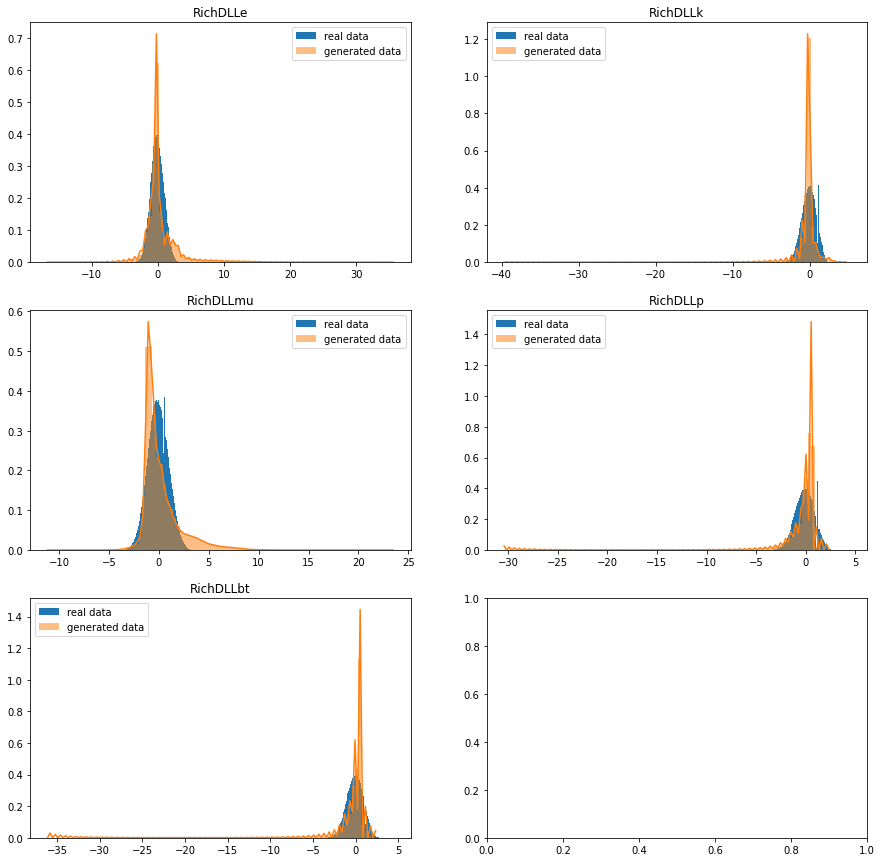

In [30]:
pruning_metrics = {}
generator = copy.deepcopy(netG)

hidden_layer = 0
for layer in generator.layers:
    if isinstance(layer, torch.nn.Sequential):
        linear_layer = layer[0]
        if hidden_layer == 0:
            amount = 60
        else:
            amount = 20
        for i in range(0, amount, 5):
            prune.l1_unstructured(linear_layer, name='weight_orig', amount=0.5)
            # TODO
            generator = train(generator)
        prune.remove(linear_layer, 'weight_orig')
        hidden_layer += 1

dlls, generated, weights, features = generate(generator)
hists.plot_1d_hist(dlls, generated, hist_kws={'weights': weights})

# kolmogorov-smirnov
ks_metrics = []
for i in range(5):
    ks_metrics.append(kolmogorov_smirnov.ks_2samp_w(dlls[:, i], generated[:, i], weights, weights))
pruning_metrics['ks'] = ks_metrics

# roc auc
pruning_metrics['auc'] = classification.calculate_rocauc(config, pd.DataFrame(features, columns=['a', 'b', 'c']), pd.DataFrame(dlls), pd.DataFrame(generated), weights)

In [32]:
total_flops, after_pruning = flops(generator, next(iter(val_loader))[0])
(total_flops - after_pruning) / total_flops

0.15463917525773196

In [56]:
## calculate time in cpu
netG = netG.eval()

import time

x = next(iter(val_loader))[0]

start_time = time.time()
with torch.no_grad():
    for _ in range(50000):
        netG(x)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 278.988028049469 seconds ---
